# Importación de las librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date,timedelta
import statistics
import plotly.express as px
import six

# Lectura de las base de datos

Se esta toamando la base de datos publicada en Open Data Colombia por la INS la cual se actualizara con los datos más recientes cada vez que se ejecute el código.

In [2]:
covid = pd.read_csv("https://www.datos.gov.co/api/views/gt2j-8ykr/rows.csv", sep=",", encoding='utf-8')
covid.head()

C:\Users\ESTEBAN\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (10,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


ID de caso    Fecha de notificación  Código DIVIPOLA  Ciudad de ubicación  \
0           1  2020-03-02T00:00:00.000            11001          Bogotá D.C.   
1           2  2020-03-06T00:00:00.000            76111  Guadalajara de Buga   
2           3  2020-03-07T00:00:00.000             5001             Medellín   
3           4  2020-03-09T00:00:00.000             5001             Medellín   
4           5  2020-03-09T00:00:00.000             5001             Medellín   

  Departamento o Distrito     atención  Edad Sexo         Tipo Estado  ...  \
0              Bogotá D.C.  Recuperado    19    F    Importado   Leve  ...   
1          Valle del Cauca  Recuperado    34    M    Importado   Leve  ...   
2                Antioquia  Recuperado    50    F    Importado   Leve  ...   
3                Antioquia  Recuperado    55    M  Relacionado   Leve  ...   
4                Antioquia  Recuperado    25    M  Relacionado   Leve  ...   

                       FIS Fecha de muerte        Fecha diagnostico  \
0  2020-02-27T00:00:00.000             NaN  2020-03-06T00:00:00.000   
1  2020-03-04T00:00:00.000             NaN  2020-03-09T00:00:00.000   
2  2020-02-29T00:00:00.000             NaN  2020-03-09T00:00:00.000   
3  2020-03-06T00:00:00.000             NaN  2020-03-11T00:00:00.000   
4  2020-03-08T00:00:00.000             NaN  2020-03-11T00:00:00.000   

          Fecha recuperado        fecha reporte web Tipo recuperación  \
0  2020-03-13T00:00:00.000  2020-03-06T00:00:00.000               PCR   
1  2020-03-19T00:00:00.000  2020-03-09T00:00:00.000               PCR   
2  2020-03-15T00:00:00.000  2020-03-09T00:00:00.000               PCR   
3  2020-03-26T00:00:00.000  2020-03-11T00:00:00.000               PCR   
4  2020-03-23T00:00:00.000  2020-03-11T00:00:00.000               PCR   

  Codigo departamento  Codigo pais  Pertenencia etnica Nombre grupo etnico  
0                  11        380.0                Otro                 NaN  
1                  76        724.0                Otro                 NaN  
2                   5        724.0                Otro                 NaN  
3                   5          NaN                Otro                 NaN  
4                   5          NaN                Otro                 NaN  

[5 rows x 21 columns]

La base de datos contiene la información individual por caso, donde cada caso es un caso confirmado, además contiene la información de la fecha de recuperación para las personas ya recuperadas, la fechad e muerte para las personas fallecidas, y las fechas de inicio de síntomas, fecha de diagnostico y la fecha en que se notifico el caso.

In [3]:
# Dimensión de las base de datos
covid.shape

(666521, 21)

### Depuración de los datos

Se crea una copia de la base de daros original descargada y a esta se le aplican las siguientes acciones:
- Eliminación de caracteres especiales como tildes, vergulillas, dieresis, etc.
- LLevar a formato fecha de python las columnas con fecha de las base de datos.
- Eliminar espacios en las valores de las columnas.
- Se estandariza los valores de la columna "Atnecion"
- Los valores que en la columna "Atencion" aparecen en NaN quieren decir que no se tiene información de si estan recuperado, muertos, etc., por lo tanto estos fueron clasificados como Fallecidos, quienes tiene fecha de muerte, y Activos, quienes no la tienen.

In [4]:
#Creamos una copia del dataset
df = covid.copy()
#Función para eliminar caracteres especiales
import unicodedata
def car_espe(lista):
    return(unicodedata.normalize('NFKD', lista).encode('ascii', 'ignore').decode('utf-8', 'ignore'))

#Se eliminan caracteres especiales y espacios en atras y adelante de los encabezados
df.columns = [car_espe(h).strip() for h in df.columns]

#Cambio a formato de fecha Fecha de notificacion
df['Fecha de notificacion'] = pd.to_datetime([f.split('T')[0] for f in df['Fecha de notificacion']])
df['Fecha de muerte'] = pd.to_datetime([f[:10] for f in df['Fecha de muerte'].astype(str)])
df['Fecha recuperado'] = pd.to_datetime([f[:10] for f in df['Fecha recuperado'].astype(str)])

df = df.sort_values('Fecha de notificacion')

# Los valores con "nan" en la columna atencio corresponden para los casos de los cuales no se tiene información
#pero son tomados como casos confirmados por lo tanto se tomaran como casos activos
#Ajuste de los nan en atencion por activos o fallecidos
for i in df.index:
    if pd.isnull(df['atencion'][i]):
        if pd.isnull(df['Fecha de muerte'][i]):
            df['atencion'][i] = 'Activo'
        else:
            df['atencion'][i] = 'Fallecido'

#Eliminar caracteres especiales del nombre de la ciudad y del departamento
df['Ciudad de ubicacion'] = [car_espe(f).strip().replace('.','') for f in df['Ciudad de ubicacion']]
df['Departamento o Distrito'] = [car_espe(f).strip() for f in df['Departamento o Distrito']]

df['atencion'] = [f.capitalize().strip() for f in df['atencion']]

df = df[['Fecha de notificacion','Fecha de muerte','Fecha recuperado','Ciudad de ubicacion','atencion','Edad','Sexo']]
df.columns = ['fecha_notificacion','fecha_muerte','fecha_recuperado','ciudad','atencion','edad','sexo']
df.tail()

<ipython-input-4-c6e50a7e4f76>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['atencion'][i] = 'Fallecido'
<ipython-input-4-c6e50a7e4f76>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['atencion'][i] = 'Activo'


fecha_notificacion fecha_muerte fecha_recuperado               ciudad  \
658937         2020-09-05          NaT              NaT          Bucaramanga   
659427         2020-09-05          NaT              NaT  Cartagena de Indias   
659426         2020-09-05          NaT              NaT  Cartagena de Indias   
659052         2020-09-05          NaT              NaT             Medellin   
659131         2020-09-05          NaT              NaT              Segovia   

        atencion  edad sexo  
658937      Casa    75    M  
659427      Casa    65    M  
659426      Casa    45    F  
659052  Hospital    54    M  
659131  Hospital    63    M

###### Histogramas de frecuencia del número de casos confirmados para Colombia y sus 5 principales ciudades

In [13]:
!mkdir histogramas_edad

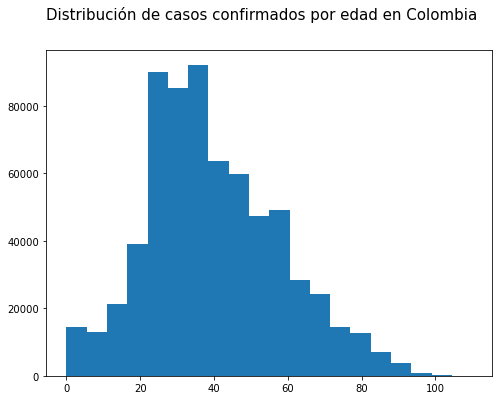

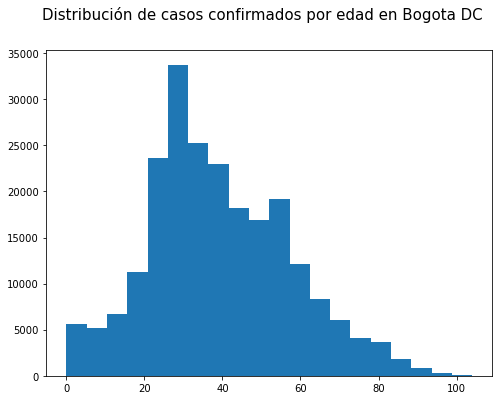

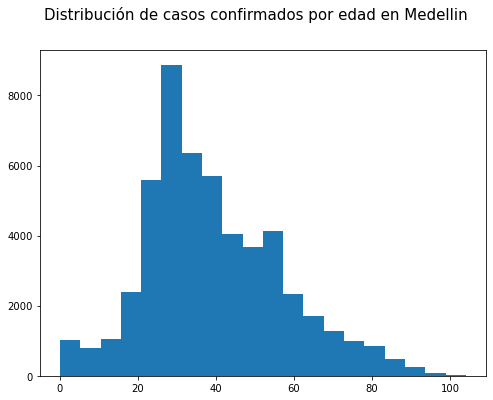

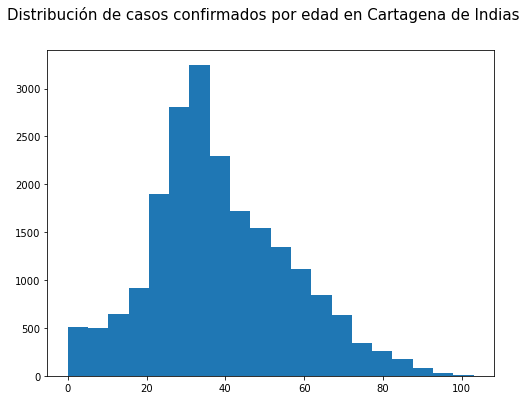

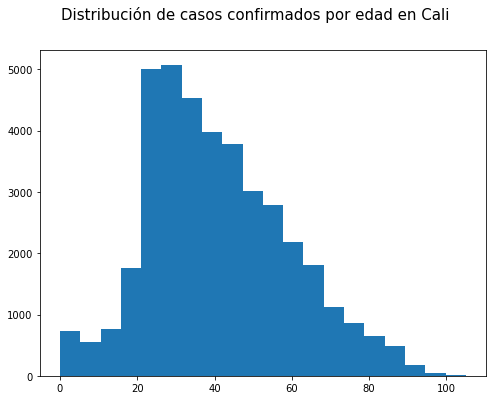

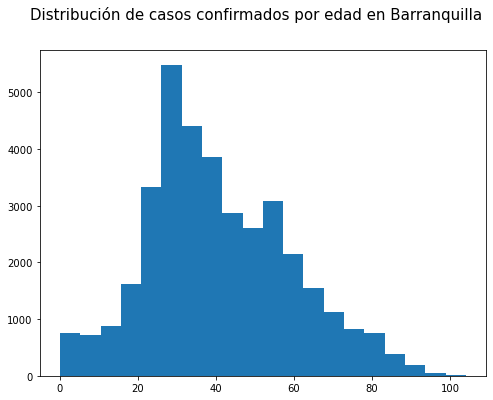

In [57]:
#Las graficas quedan guardas en la ruta figuras/histogramas_edad/
ciudades = ['Colombia', 'Bogota DC', 'Medellin', 'Cartagena de Indias', 'Cali', 'Barranquilla']
for i in ciudades:
    if i == "Colombia":
        ciu = df.copy()
    else:
        ciu = df[df['ciudad'] == i]
        
    fig, ax = plt.subplots(1, figsize=(8, 6))
    fig.suptitle('Distribución de casos confirmados por edad en ' + str(i), fontsize=15)
    ax.hist(ciu['edad'], bins=20)
    fig = plt.savefig('figuras/histogramas_edad/' + 'edad_' + str(i) + '.png')

# Contrucción del Modelo SIRM a partir de los datos y los pronosticos

<p>La función que se define contruye la una tabla con el número de infectados para cada días con una media movil de 7 días, esto con el fin de suavisar un poco la curva de los casoso confirmados. Este procedimiento se realiza de la misma forma para los recuperados y los fallecidos. Además contruye el numero de casos activos por días y el número de personas suceptibles al contagio. También hace el calculo del beta (tasa de infección), gamma (tasa de recuperación) y delta (tasa de muestre) para cada uno de los días; a partir de estos valores es que se hará el pronostico.</p>

<p>La función toma como entradas un DataFrame, el nombre de la ciudad para la cual se va a hacer la contrucción, el tiempo para el pronostico y el escenrio de los parametros de los betas, que son:</p>

- last_param: Último par+ametro calculado con los datos de la base.
- last_param_cal: Se calculan los parametros con los valores de los pronosticos y se toma este ultimo.
- prom_param: Toma el promedio de los últimos 7 días de los parámetros calculados con los datos de la base


In [58]:
# Poblacion de las Colombia y las ciudades que se van a modelar
poblacion = {'Colombia': 50882884, 'Bogota DC': 7743955, 'Medellin': 2933094, 'Cartagena de Indias': 1028736,
             'Cali': 2497562, 'Barranquilla': 1243113}

#Ingresa el DataFrame del covid ( definido como df) y el entre comillas el nombre de la ciudad a calcular
def data_sirm_pron(df, ciudad, periodo_pronostico, cal_parametros):
    
    #Filtro de la ciudad a revisar
    if ciudad == "Colombia":
        df1 = df.copy()
    else:
        df1 = df[df['ciudad'] == ciudad]

    #Dataframe predefinido con el listado de fechas
    df_fecha = pd.DataFrame(np.unique(df1['fecha_notificacion']))
    df_fecha.columns = ['fecha']    

    # Calculo del numero de infectados por día
    df_sirm = df1.groupby(['fecha_notificacion'], as_index=False)['atencion'].count()
    df_sirm.columns = ['fecha','infectados']
    # Calculo del promedio movil de 7 dias del numero de infectados por dia y el acumulado
    df_sirm['infectados'] = df_sirm['infectados'].rolling(7).mean()
    df_sirm = df_sirm.dropna()
    df_sirm['infectados_acum'] = df_sirm['infectados'].cumsum()

    # Calculo del numero de infectados resuperados por dia, el promedio movil de 7 dias y el acumulado
    df_recu = df1[df1['atencion'] == 'Recuperado'].groupby(['fecha_recuperado'], as_index=False)['atencion'].count()
    df_recu.columns = ['fecha','recuperados']
    df_recu = df_fecha.merge(df_recu, on='fecha', how='left')
    df_recu['recuperados'].fillna(0, inplace=True) #Reemplza los NaN por 0
    df_recu['recuperados'] = df_recu['recuperados'].rolling(7).mean() #promedio movil de 7 dias
    df_recu['recuperados_acum'] = df_recu['recuperados'].cumsum() #acumulado

    # Concatenando la infroamción de recuperado en la base de df_sirm
    df_sirm = df_sirm.merge(df_recu, on='fecha', how='left')

    # Calculo del numero de infectados muertos por dia, el promedio movil de 7 dias y el acumulado
    df_muerto = df1[df1['atencion'] == 'Fallecido'].groupby(['fecha_muerte'], as_index=False)['atencion'].count()
    df_muerto.columns = ['fecha','fallecidos']
    df_muerto = df_fecha.merge(df_muerto, on='fecha', how='left')
    df_muerto['fallecidos'].fillna(0, inplace=True) #Reemplza los NaN por 0
    df_muerto['fallecidos'] = df_muerto['fallecidos'].rolling(7).mean() #promedio movil de 7 dias
    df_muerto['fallecidos_acum'] = df_muerto['fallecidos'].cumsum() #acumulado

    # Concatenando la infroamción de fallecidos en la base de df_sirm
    df_sirm = df_sirm.merge(df_muerto, on='fecha', how='left')
    
    # Obtencion de los betas, gammas y deltas
    N = poblacion.get(ciudad) #Obtiene el el total de la poblacion de acuerdo a la ciudad definida en el diccionario
    
    # N = Total de la poblacion
    # S = Suceptibles
    # I = Infectados
    # R = Recuperados
    # F = Fallecidos
    # A = Infectados Activos
    df_sirm['activos'] = df_sirm['suceptibles'] = df_sirm['beta'] = df_sirm['gamma'] = df_sirm['delta'] = float()
    df_sirm['description'] = ""

##################################################
# Contruccion de la tabla del SIRM con los datos #

    for t in range(len(df_sirm['fecha'])):
        #print(t)
        df_pron = pd.DataFrame()
        
        if t == 0:
            df_sirm['activos'][t] = df_sirm['infectados'][t] #Activos en el dia 0 son los contagiados ese dia
            df_sirm['suceptibles'][t] = N - df_sirm['infectados'][t] #Sucetibles en el día 0 es total de la poblacion menos los contagiados en ese dia
            df_sirm['beta'][t] = df_sirm['gamma'][t] = df_sirm['delta'][t] = 0
            df_sirm['description'] = "Real" 
            
        else:
            # A(t) = A(t-1) + I(t) - R(t) - F(t)
            df_sirm['activos'][t] = df_sirm['activos'][t-1] + df_sirm['infectados'][t] - df_sirm['recuperados'][t] - df_sirm['fallecidos'][t]
            # S(t) = S(t-1) - I(t)
            df_sirm['suceptibles'][t] = df_sirm['suceptibles'][t-1] - df_sirm['infectados'][t]
            # beta = (I(t) * N)/(A(t-1)*S(t-1))
            df_sirm['beta'][t] = (df_sirm['infectados'][t] * N) / (df_sirm['activos'][t-1] * df_sirm['suceptibles'][t-1])
            # gamma = R(t) / A(t-1)
            df_sirm['gamma'][t] = df_sirm['recuperados'][t] / df_sirm['activos'][t-1]
            # delta = F(t) / A(t-1)
            df_sirm['delta'][t] = df_sirm['fallecidos'][t] / df_sirm['activos'][t-1]
            df_sirm['description'] = "Real"
            
# Fin de la contruccion de la tabla del modelo SIRM con los datos #
###################################################################
    
    df_param = df_sirm.copy()
    
    for i in range(len(df_param['fecha']), len(df_param['fecha']) + periodo_pronostico):
        df_pron = pd.DataFrame()

        if cal_parametros == 'last_param': # Ultimo parametro calculado con los datos
            beta = df_param['beta'].iloc[-1]
            gamma = df_param['gamma'].iloc[-1]
            delta = df_param['delta'].iloc[-1]        
        
        elif cal_parametros == 'last_param_cal': # Ultimo dato calculado
            beta = df_sirm['beta'].iloc[-1]
            gamma = df_sirm['gamma'].iloc[-1]
            delta = df_sirm['delta'].iloc[-1]
            
        else: #Promedio ultimos 7 dias calculado con los datos
            beta = df_param['beta'][-7:].mean()
            gamma = df_param['gamma'][-7:].mean()
            delta = df_param['delta'][-7:].mean()


        #Calculo de los pronosticos
        df_pron['fecha'] = [pd.to_datetime(df_sirm['fecha'][i-1] + timedelta(days = 1))]

        # I(t) = (beta * A(t-1) * S(t-1)) / N
        if df_sirm['infectados_acum'][i-1] >= N:
            df_pron['infectados'] = [0]
        else:
            df_pron['infectados'] = [((beta * df_sirm['activos'][i-1] * df_sirm['suceptibles'][i-1]) / N)]            
         
        
        df_pron['infectados_acum'] = [df_sirm['infectados_acum'][i-1] + df_pron['infectados'][0]]
        # R(t) = A(t-1) * gamma
        df_pron['recuperados'] = [df_sirm['activos'][i-1] * gamma]
        df_pron['recuperados_acum'] = [df_sirm['recuperados_acum'][i-1] + df_pron['recuperados'][0]]

        # F(t) = A(t-1) * delta
        df_pron['fallecidos'] = [df_sirm['activos'][i-1] * delta]
        df_pron['fallecidos_acum'] = [df_sirm['fallecidos_acum'][i-1] + df_pron['fallecidos'][0]]

        # A(t) = A(t-1) + I(t) - R(t) - F(t)
        df_pron['activos'] = [df_sirm['activos'][i-1] + df_pron['infectados'][0] - df_pron['recuperados'][0] - df_pron['fallecidos'][0]]

        # S(t) = S(t-1) - I(t)
        df_pron['suceptibles'] = [df_sirm['suceptibles'][i-1] - df_pron['infectados'][0]]
        
        if cal_parametros == 'last_param': # Ultimo parametro calculado con los datos        
            df_pron['beta'] = beta
            df_pron['gamma'] = gamma
            df_pron['delta'] = delta
        elif cal_parametros == 'last_param_cal': # Ultimo dato calculado
            df_pron['beta'] = (df_pron['infectados'][0] * N) / (df_sirm['activos'][t-1] * df_sirm['suceptibles'][t-1])
            # gamma = R(t) / A(t-1)
            df_pron['gamma'] = df_pron['recuperados'][0] / df_sirm['activos'][t-1]
            # delta = F(t) / A(t-1)
            df_pron['delta'] = df_pron['fallecidos'][0] / df_sirm['activos'][t-1]
        else:
            df_pron['beta'] = beta
            df_pron['gamma'] = gamma
            df_pron['delta'] = delta
            
        df_pron['description'] = 'Pronostico'
        
        df_sirm = df_sirm.append(df_pron).reset_index(drop=True)

    # Retorna un data frame
    return df_sirm  

### Contrucción de los pronósticos a 15 días y los intervalos de confianza

In [59]:
ciudades = list(poblacion.keys())
ciudad = ['Colombia', 'Bogota DC', 'Medellin', 'Cartagena de Indias', 'Cali', 'Barranquilla']
periodo_pronostico = [15,30]
cal_parametros = ['last_param', 'last_param_cal', 'prom_param']

df_pron15 = pd.DataFrame()
for ciudad in ciudades:
    
    for param in cal_parametros:
        
        df_calculo = data_sirm_pron(df, ciudad, periodo_pronostico[0], param)
        df_calculo['ciudad'] = ciudad
        df_calculo['escenario'] = param
        df_calculo = df_calculo[['fecha','ciudad','escenario','suceptibles','infectados','recuperados','fallecidos','activos','description']]
        
        #columnas con los pornosticos
        df_calculo['pronostico_infectados'] = df_calculo['infectados']
        df_calculo['pronostico_recuperados'] = df_calculo['recuperados']
        df_calculo['pronostico_fallecidos'] = df_calculo['fallecidos']
        df_calculo['pronostico_activos'] = df_calculo['activos']
        
        df_calculo['ICi_infectados'] = df_calculo['infectados']
        df_calculo['ICs_infectados'] = df_calculo['infectados']
        df_calculo['ICi_recuperados'] = df_calculo['recuperados']
        df_calculo['ICs_recuperados'] = df_calculo['recuperados']
        df_calculo['ICi_fallecidos'] = df_calculo['fallecidos']
        df_calculo['ICs_fallecidos'] = df_calculo['fallecidos']
        df_calculo['ICi_activos'] = df_calculo['activos']
        df_calculo['ICs_activos'] = df_calculo['activos']
        
        #datos pronosticos
        df_cal1 = df_calculo.iloc[-15:,:]
        
        #datos sin pronosticos
        df_calculo = df_calculo.iloc[:-15,:]
        
        df_pron = df_calculo.iloc[:-15,:]
        
        #calculo IC
        df_cal1['ICi_infectados'] = df_cal1['infectados'] - statistics.stdev(df_cal1['infectados'])
        df_cal1['ICs_infectados'] = df_cal1['infectados'] + statistics.stdev(df_cal1['infectados']) 
        
        df_cal1['ICi_recuperados'] = df_cal1['recuperados'] - statistics.stdev(df_cal1['recuperados'])
        df_cal1['ICs_recuperados'] = df_cal1['recuperados'] + statistics.stdev(df_cal1['recuperados'])
        
        df_cal1['ICi_fallecidos'] = df_cal1['fallecidos'] - statistics.stdev(df_cal1['fallecidos'])
        df_cal1['ICs_fallecidos'] = df_cal1['fallecidos'] + statistics.stdev(df_cal1['fallecidos'])
        
        df_cal1['ICi_activos'] = df_cal1['activos'] - statistics.stdev(df_cal1['activos'])
        df_cal1['ICs_activos'] = df_cal1['activos'] + statistics.stdev(df_cal1['activos'])
        
        df_calculo = df_calculo.append(df_cal1)
        
        # ultimos valores de infectados, receuperados, fallecidos y activos
        ajuste = ['infectados','recuperados','fallecidos','activos']
        
        for f in range(len(df_calculo['infectados'][:-15]),len(df_calculo['infectados'])):
            df_calculo['infectados'][f] = None
        
        for f in range(len(df_calculo['recuperados'][:-15]),len(df_calculo['recuperados'])):
            df_calculo['recuperados'][f] = None
            
        for f in range(len(df_calculo['fallecidos'][:-15]),len(df_calculo['fallecidos'])):
            df_calculo['fallecidos'][f] = None
            
        for f in range(len(df_calculo['activos'][:-15]),len(df_calculo['activos'])):
            df_calculo['activos'][f] = None
        
        df_pron15 = pd.concat([df_pron15,df_calculo])


<ipython-input-58-6a3870714f2d>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sirm['activos'][t] = df_sirm['infectados'][t] #Activos en el dia 0 son los contagiados ese dia
<ipython-input-58-6a3870714f2d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sirm['suceptibles'][t] = N - df_sirm['infectados'][t] #Sucetibles en el día 0 es total de la poblacion menos los contagiados en ese dia
<ipython-input-58-6a3870714f2d>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

In [60]:
prueba = df_pron15[(df_pron15['ciudad']== 'Bogota DC') & (df_pron15['escenario']== param)]
prueba.head()

fecha     ciudad   escenario   suceptibles  infectados  recuperados  \
0 2020-03-14  Bogota DC  prom_param  7.743951e+06    3.714286     0.285714   
1 2020-03-15  Bogota DC  prom_param  7.743947e+06    4.285714     0.285714   
2 2020-03-16  Bogota DC  prom_param  7.743942e+06    5.428571     0.285714   
3 2020-03-17  Bogota DC  prom_param  7.743934e+06    7.428571     0.285714   
4 2020-03-18  Bogota DC  prom_param  7.743925e+06    8.857143     0.285714   

   fallecidos    activos description  pronostico_infectados  ...  \
0         0.0   3.714286        Real               3.714286  ...   
1         0.0   7.714286        Real               4.285714  ...   
2         0.0  12.857143        Real               5.428571  ...   
3         0.0  20.000000        Real               7.428571  ...   
4         0.0  28.571429        Real               8.857143  ...   

   pronostico_fallecidos  pronostico_activos  ICi_infectados  ICs_infectados  \
0                    0.0            3.714286        3.714286        3.714286   
1                    0.0            7.714286        4.285714        4.285714   
2                    0.0           12.857143        5.428571        5.428571   
3                    0.0           20.000000        7.428571        7.428571   
4                    0.0           28.571429        8.857143        8.857143   

   ICi_recuperados  ICs_recuperados  ICi_fallecidos  ICs_fallecidos  \
0         0.285714         0.285714             0.0             0.0   
1         0.285714         0.285714             0.0             0.0   
2         0.285714         0.285714             0.0             0.0   
3         0.285714         0.285714             0.0             0.0   
4         0.285714         0.285714             0.0             0.0   

   ICi_activos  ICs_activos  
0     3.714286     3.714286  
1     7.714286     7.714286  
2    12.857143    12.857143  
3    20.000000    20.000000  
4    28.571429    28.571429  

[5 rows x 21 columns]

##### Gráficas con los pronosticos a 15 días y los IC para cada uno de los estados

<ipython-input-61-ebfd6d4dd9b8>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, figsize=(8, 6))
<ipython-input-61-ebfd6d4dd9b8>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, figsize=(8, 6))
<ipython-input-61-ebfd6d4dd9b8>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`

<ipython-input-61-ebfd6d4dd9b8>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, figsize=(8, 6))
<ipython-input-61-ebfd6d4dd9b8>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, figsize=(8, 6))
<ipython-input-61-ebfd6d4dd9b8>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`

<ipython-input-61-ebfd6d4dd9b8>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, figsize=(8, 6))
<ipython-input-61-ebfd6d4dd9b8>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, figsize=(8, 6))
<ipython-input-61-ebfd6d4dd9b8>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`

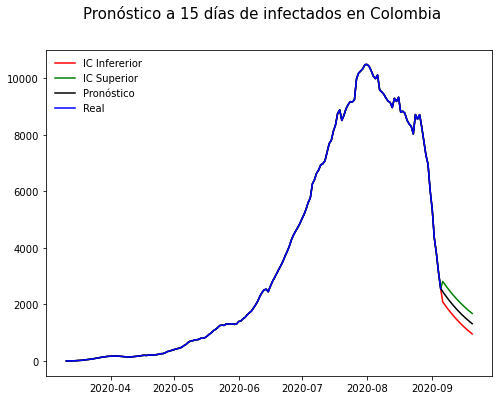

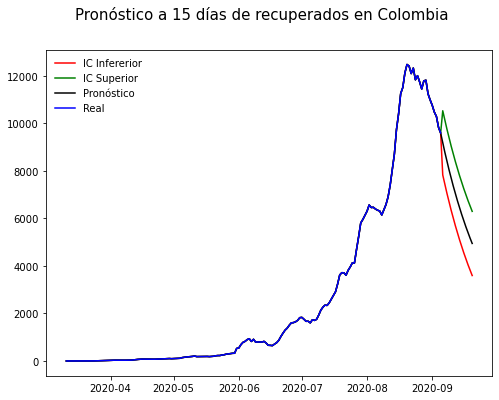

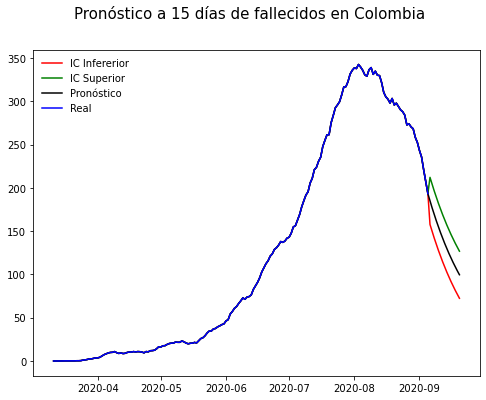

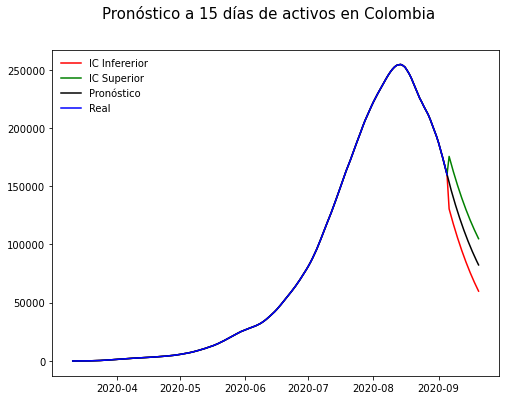

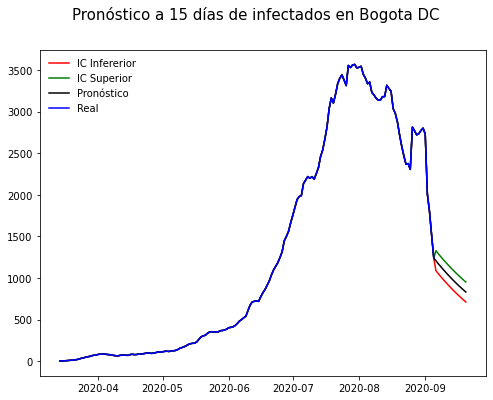

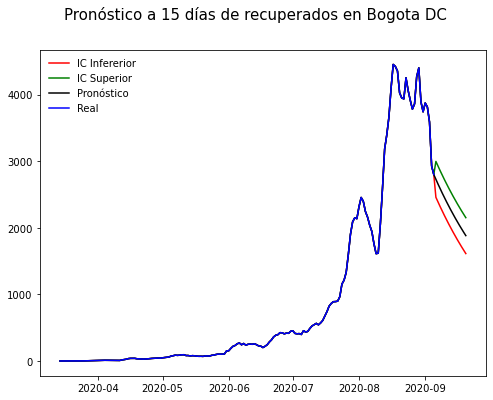

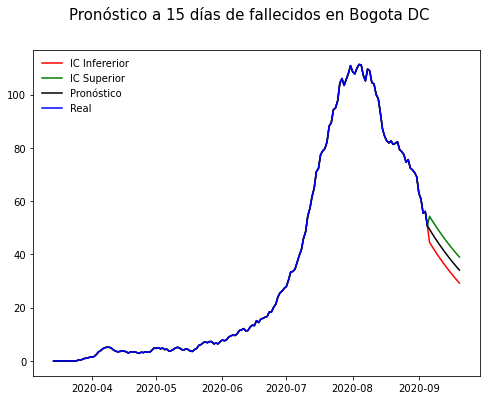

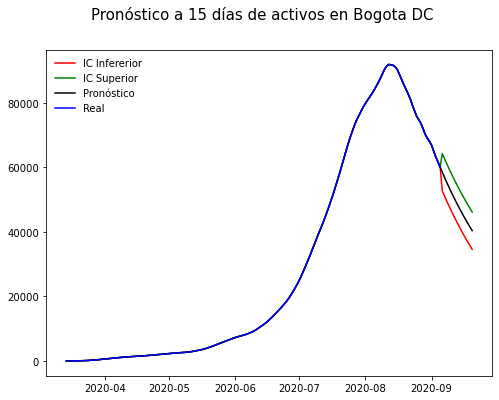

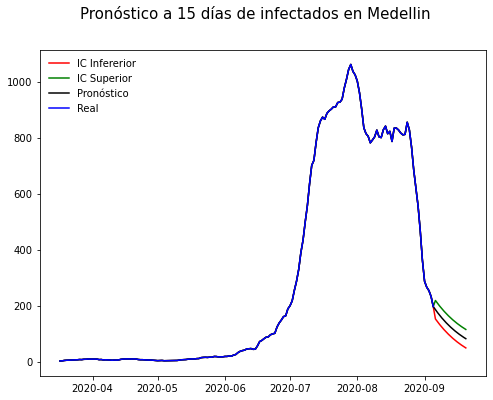

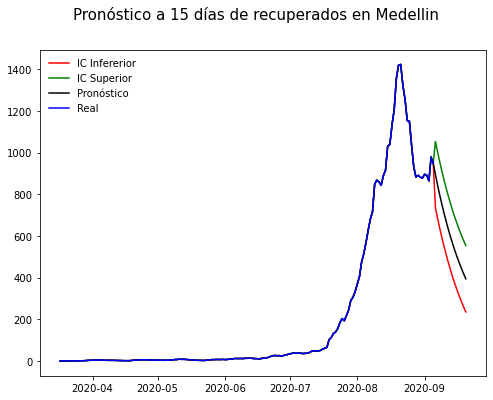

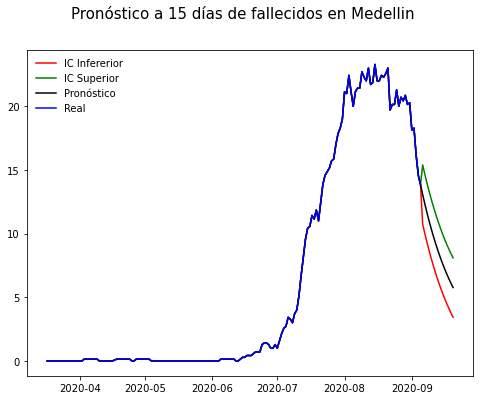

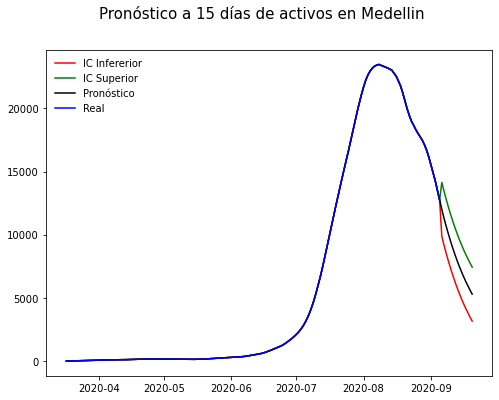

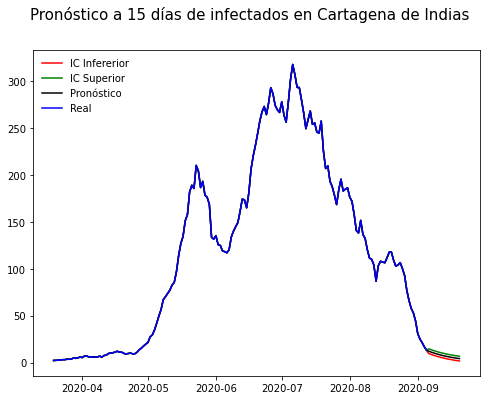

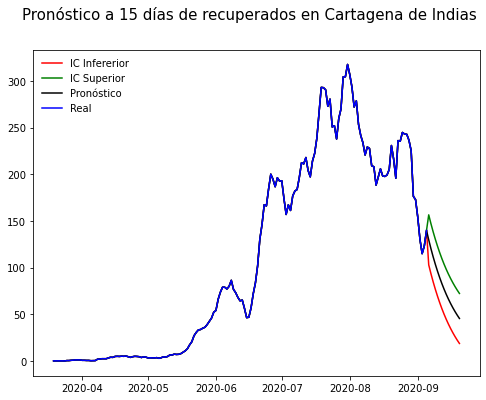

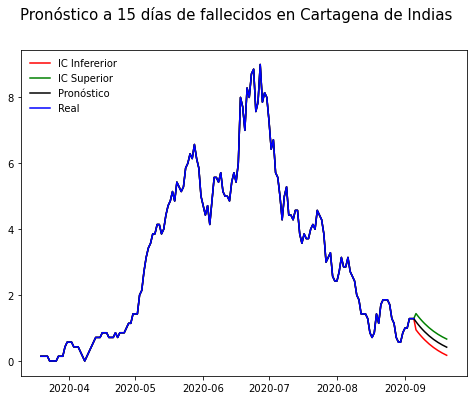

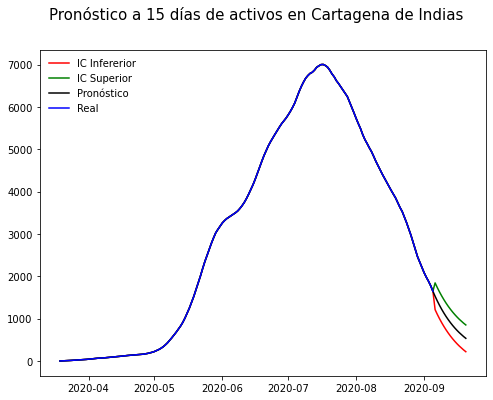

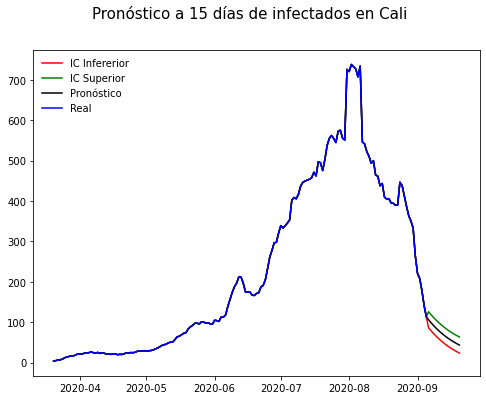

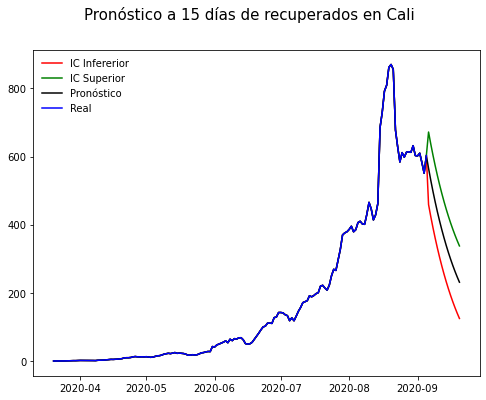

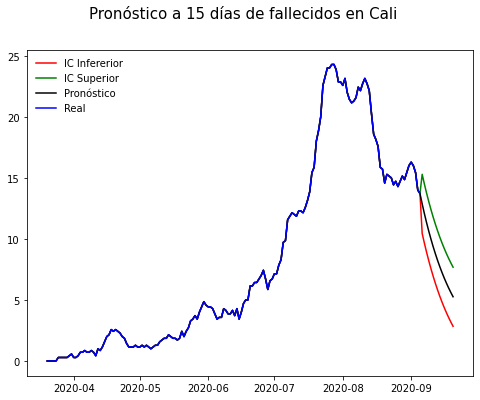

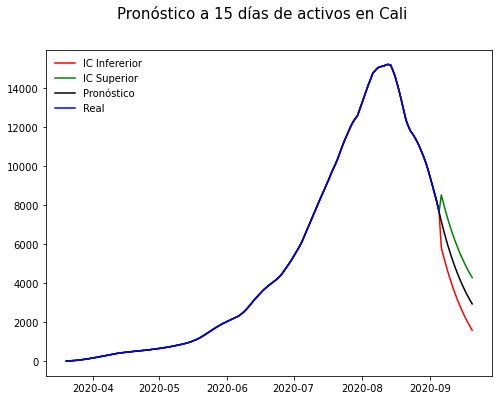

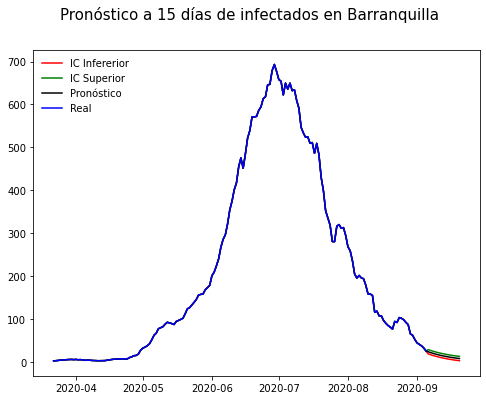

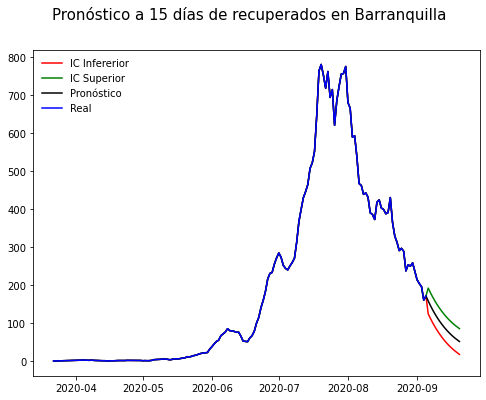

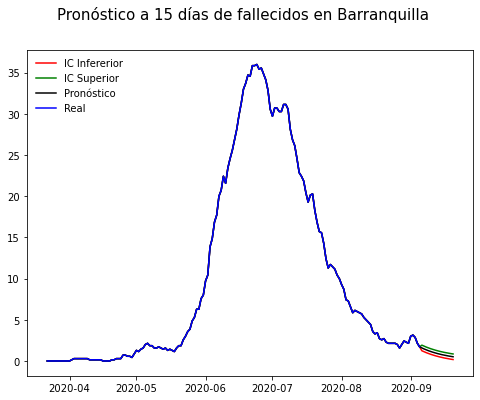

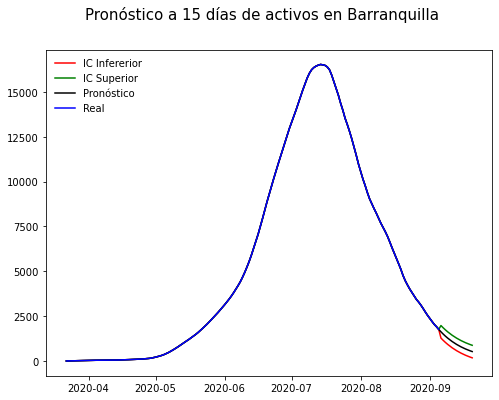

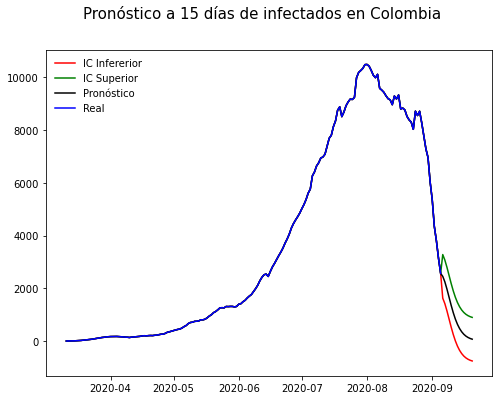

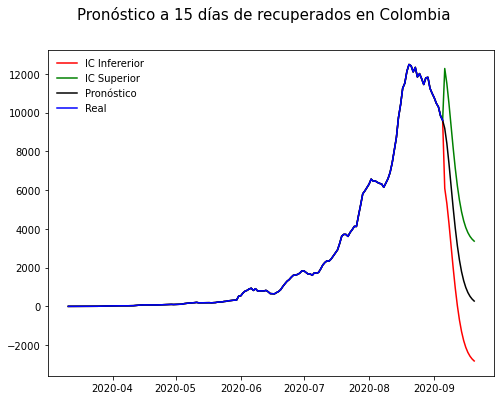

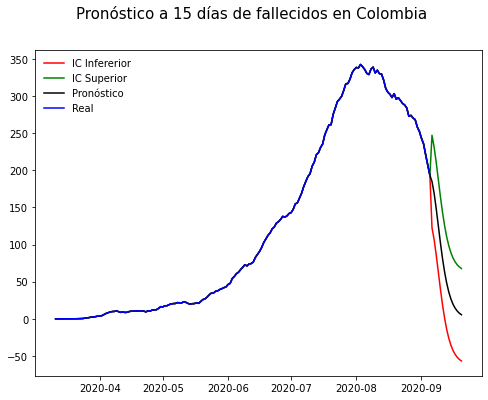

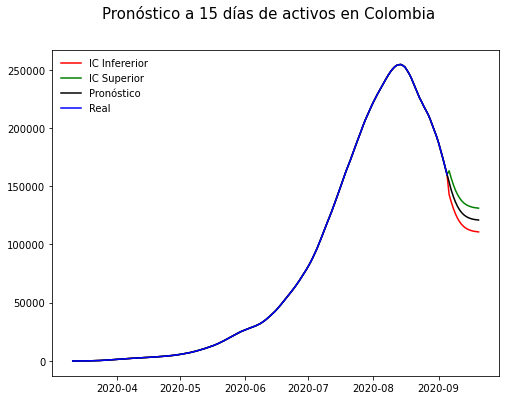

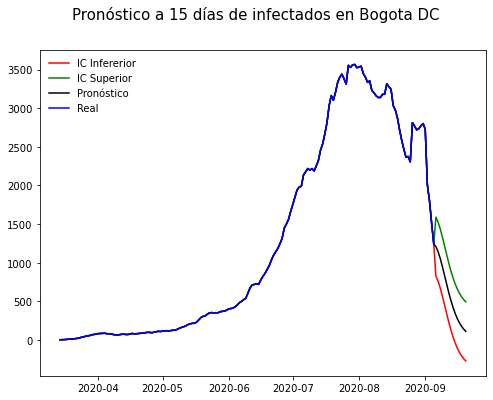

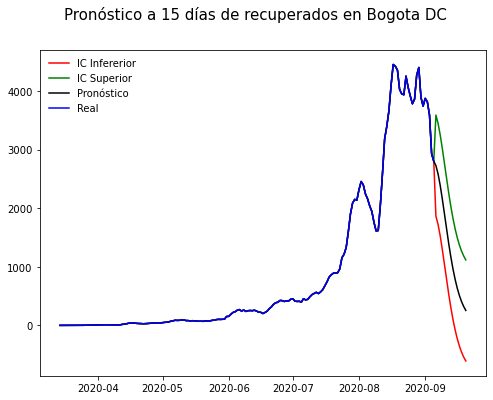

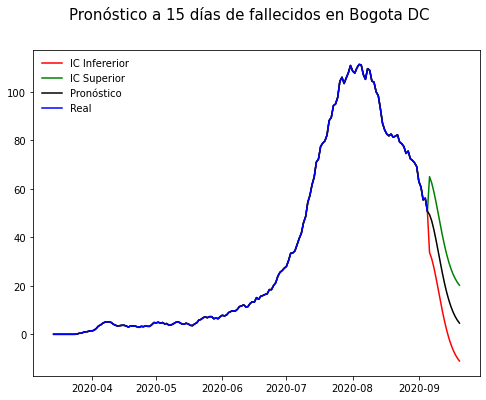

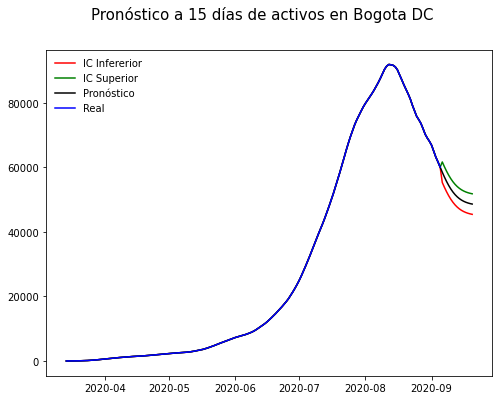

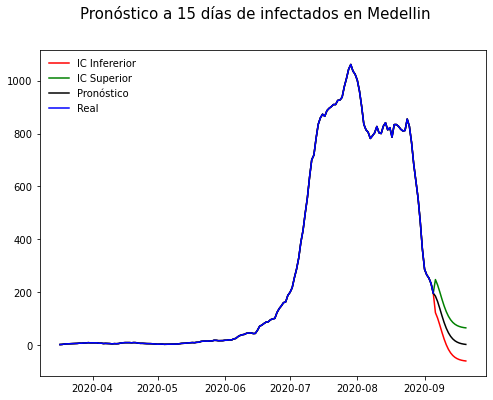

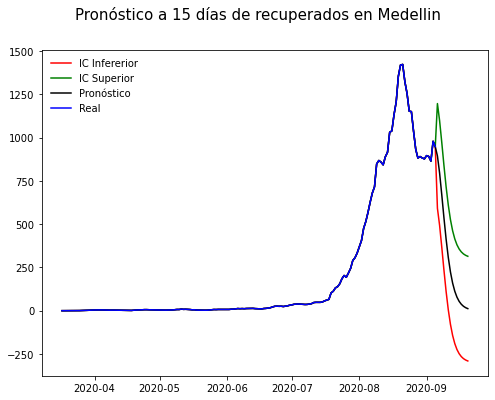

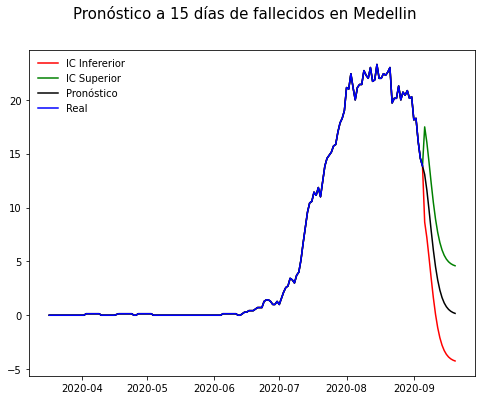

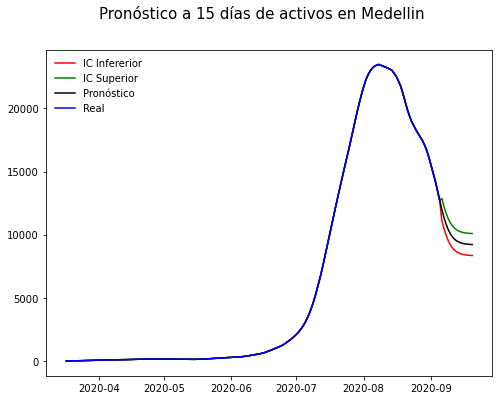

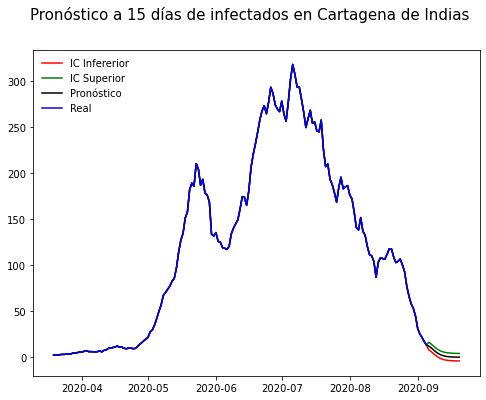

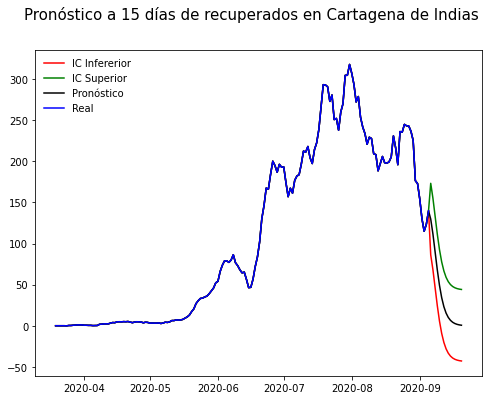

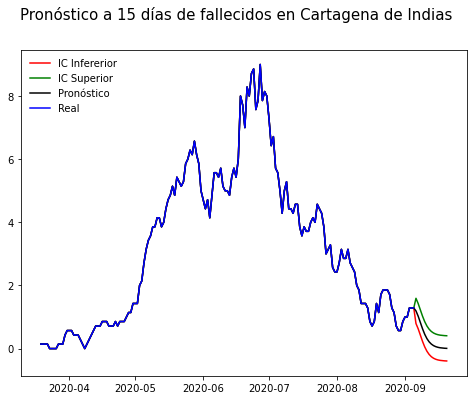

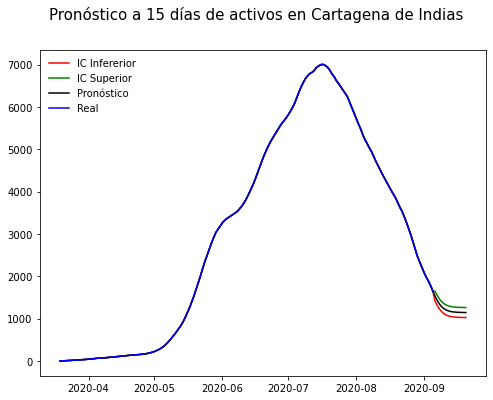

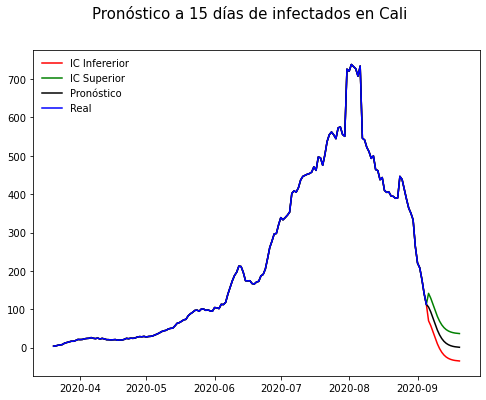

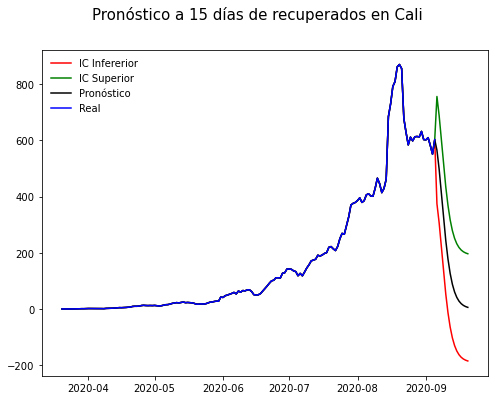

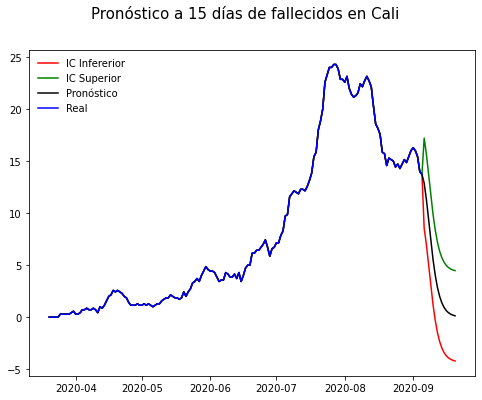

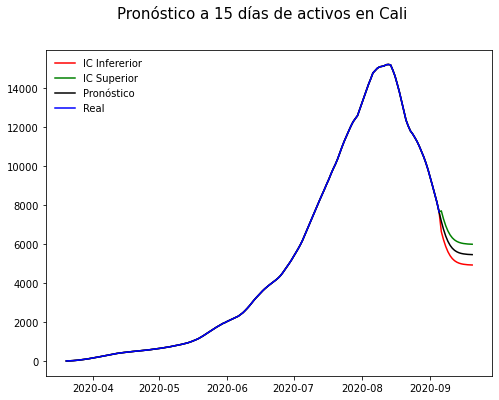

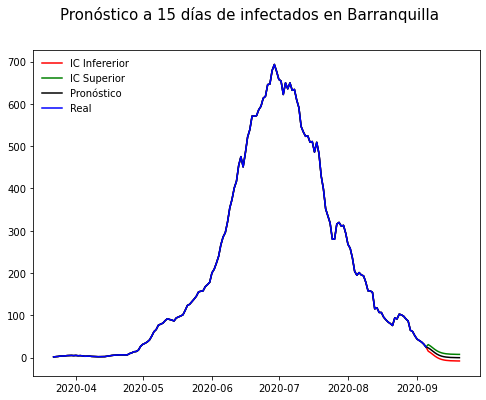

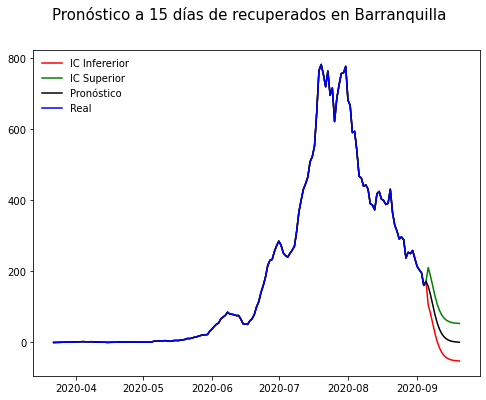

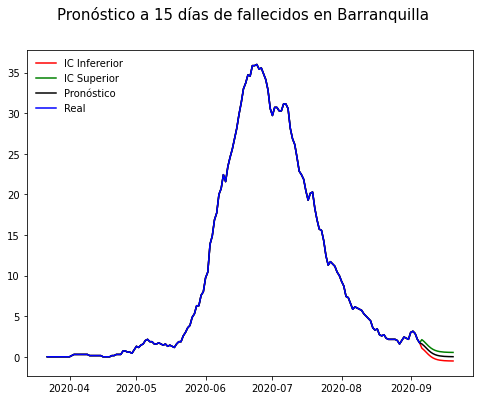

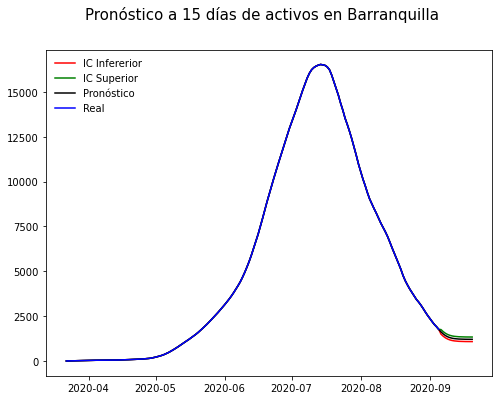

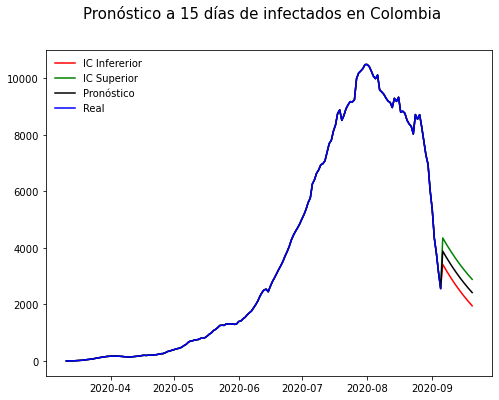

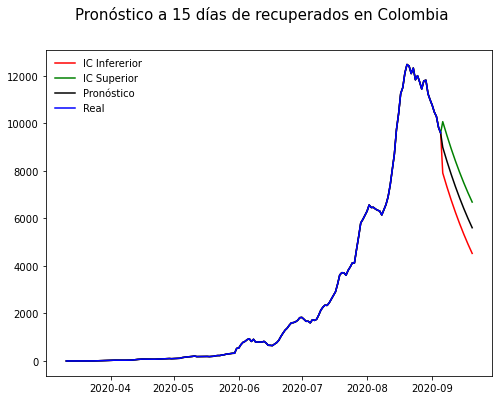

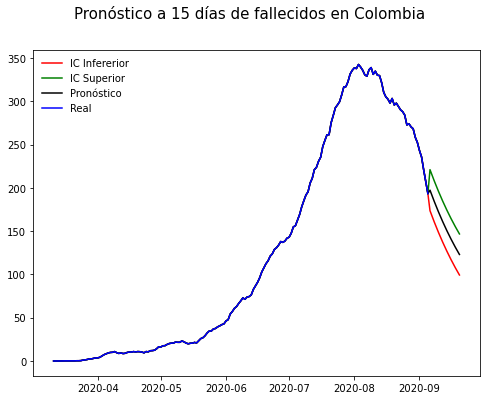

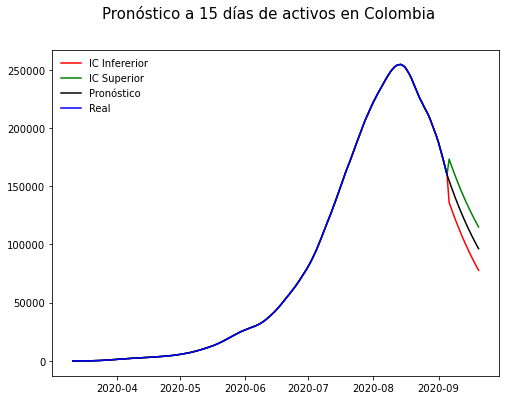

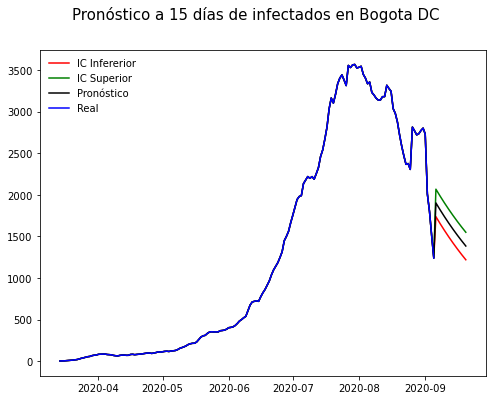

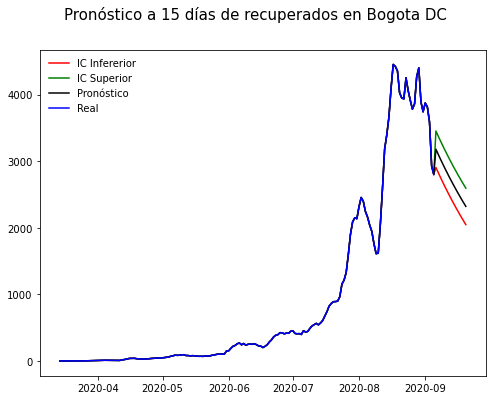

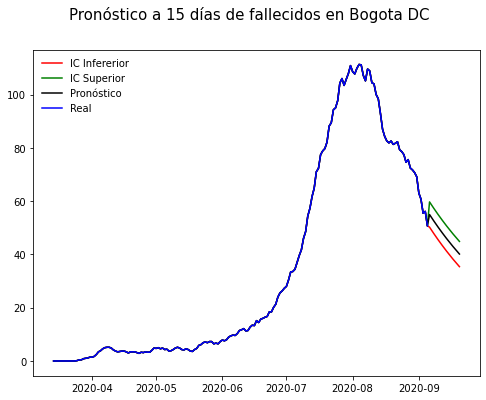

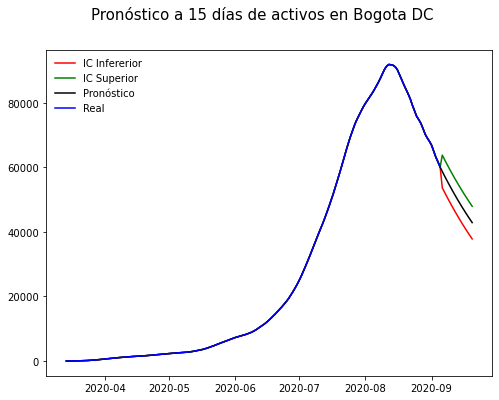

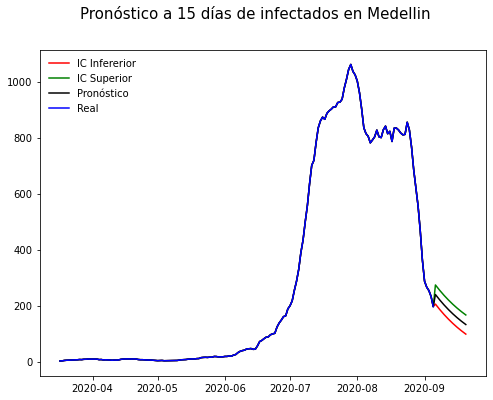

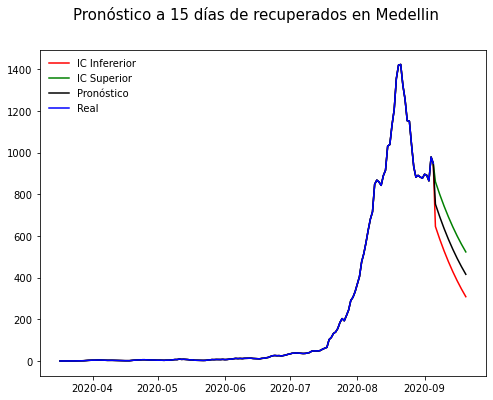

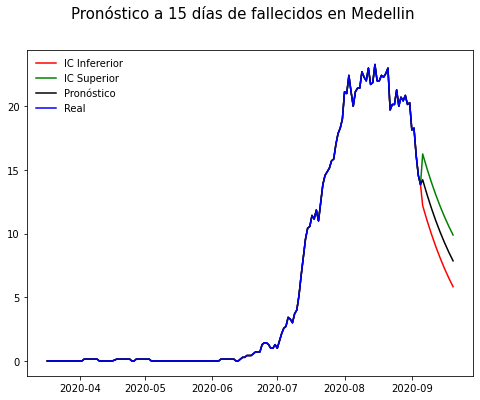

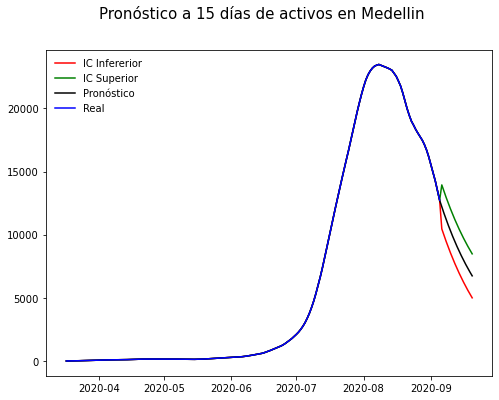

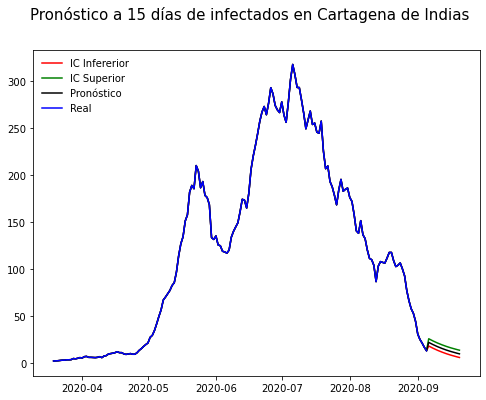

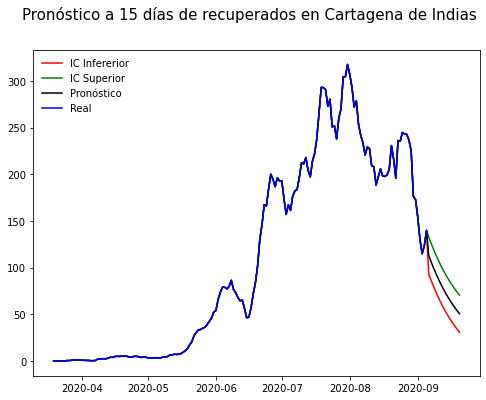

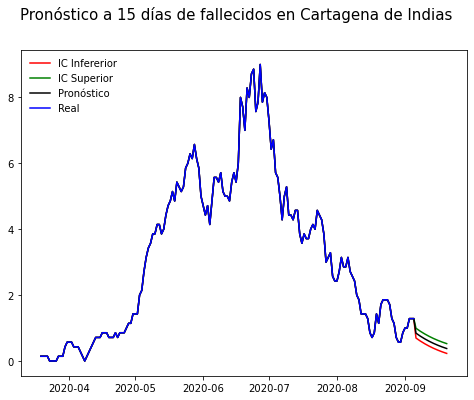

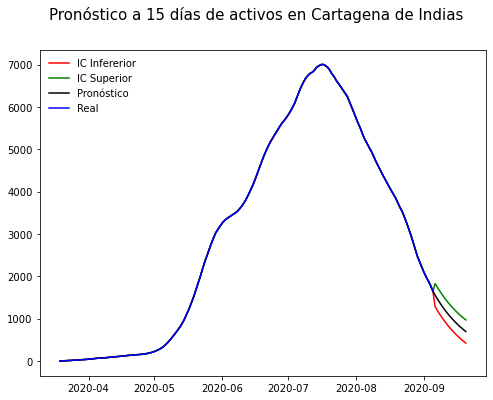

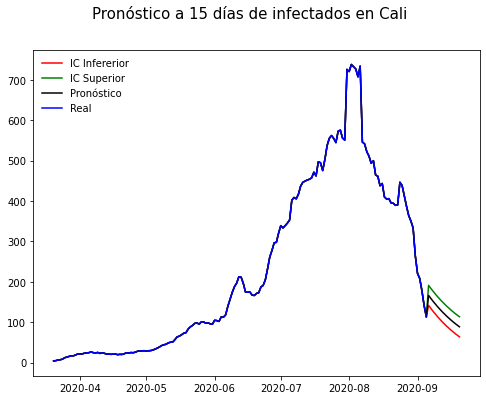

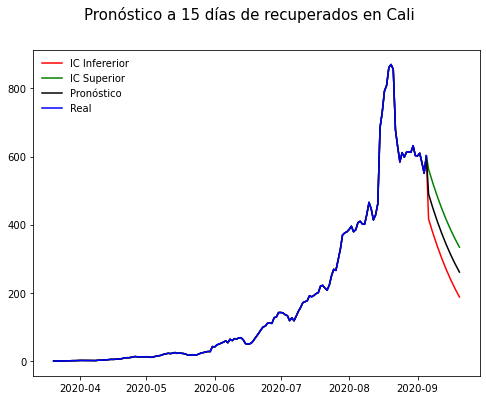

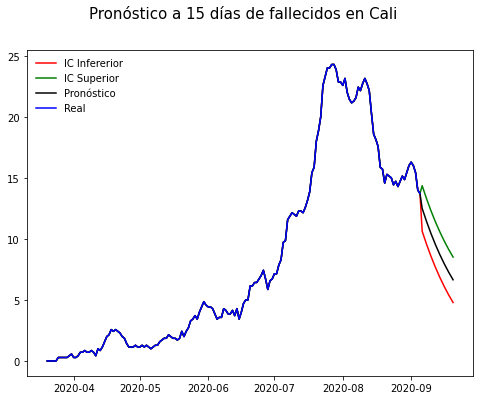

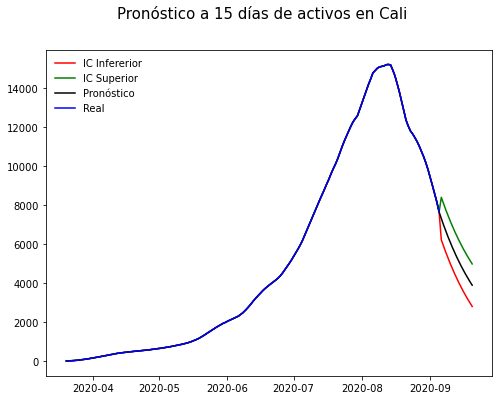

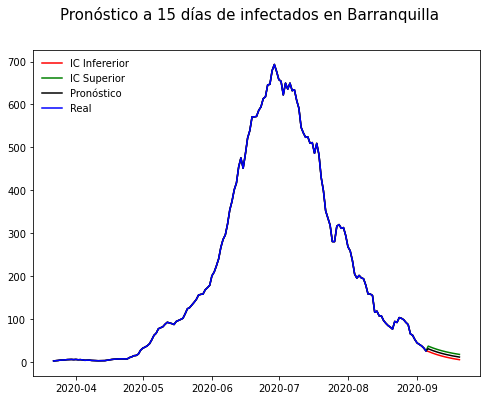

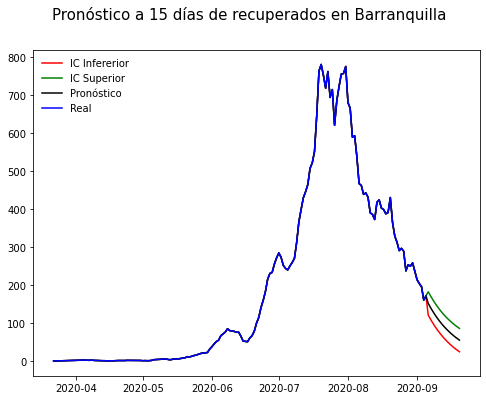

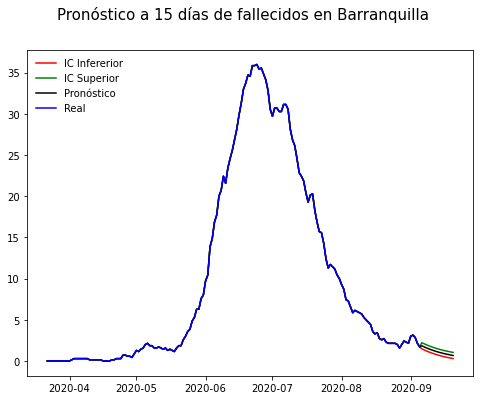

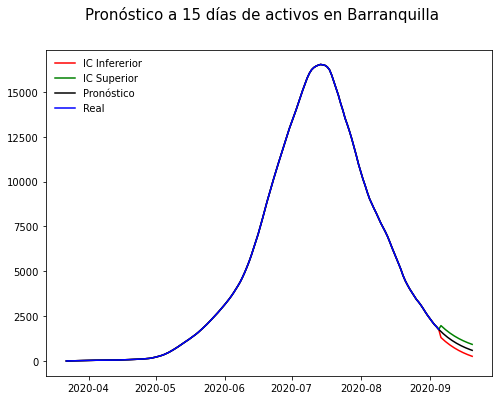

In [61]:
ciudades = ['Colombia', 'Bogota DC', 'Medellin', 'Cartagena de Indias', 'Cali', 'Barranquilla']
cal_parametros = ['last_param', 'last_param_cal', 'prom_param']
estado = ['infectados','recuperados','fallecidos','activos']
for param in cal_parametros:
    for ciudad in ciudades:
        prueba = df_pron15[(df_pron15['ciudad']== ciudad) & (df_pron15['escenario']== param)]
        
        for esta in estado:
            
            fig, ax = plt.subplots(1, figsize=(8, 6))
            fig.suptitle('Pronóstico a 15 días de ' + str(esta) + ' en ' + ciudad, fontsize=15)
            ax.plot(prueba['fecha'], prueba['ICi_'+esta], color = 'red', label="IC Infererior")
            ax.plot(prueba['fecha'], prueba['ICs_'+esta], color = 'green', label="IC Superior")
            ax.plot(prueba['fecha'], prueba['pronostico_'+esta], color='black', label="Pronóstico")
            ax.plot(prueba['fecha'], prueba[esta], color = 'blue', label='Real')
            ax.legend(loc="upper left", frameon=False)
            fig = plt.savefig('figuras/pronostico15/' + str(esta) + '/' + str(param) + '/pro_' + str(esta) + "_" + ciudad + '.png')

### Contrucción de los pronósticos a 30 días y los intervalos de confianza

In [62]:
ciudades = list(poblacion.keys())
ciudad = ['Colombia', 'Bogota DC', 'Medellin', 'Cartagena de Indias', 'Cali', 'Barranquilla']
periodo_pronostico = [15,30]
cal_parametros = ['last_param', 'last_param_cal', 'prom_param']

df_pron30 = pd.DataFrame()
for ciudad in ciudades:
    
    for param in cal_parametros:
        
        df_calculo = data_sirm_pron(df, ciudad, periodo_pronostico[1], param)
        df_calculo['ciudad'] = ciudad
        df_calculo['escenario'] = param
        df_calculo = df_calculo[['fecha','ciudad','escenario','suceptibles','infectados','recuperados','fallecidos','activos','description']]
        
        #columnas con los pornosticos
        df_calculo['pronostico_infectados'] = df_calculo['infectados']
        df_calculo['pronostico_recuperados'] = df_calculo['recuperados']
        df_calculo['pronostico_fallecidos'] = df_calculo['fallecidos']
        df_calculo['pronostico_activos'] = df_calculo['activos']
        
        df_calculo['ICi_infectados'] = df_calculo['infectados']
        df_calculo['ICs_infectados'] = df_calculo['infectados']
        df_calculo['ICi_recuperados'] = df_calculo['recuperados']
        df_calculo['ICs_recuperados'] = df_calculo['recuperados']
        df_calculo['ICi_fallecidos'] = df_calculo['fallecidos']
        df_calculo['ICs_fallecidos'] = df_calculo['fallecidos']
        df_calculo['ICi_activos'] = df_calculo['activos']
        df_calculo['ICs_activos'] = df_calculo['activos']
        
        #datos pronosticos
        df_cal1 = df_calculo.iloc[-15:,:]
        
        #datos sin pronosticos
        df_calculo = df_calculo.iloc[:-15,:]
        
        df_pron = df_calculo.iloc[:-15,:]
        
        #calculo IC
        df_cal1['ICi_infectados'] = df_cal1['infectados'] - statistics.stdev(df_cal1['infectados'])
        df_cal1['ICs_infectados'] = df_cal1['infectados'] + statistics.stdev(df_cal1['infectados']) 
        
        df_cal1['ICi_recuperados'] = df_cal1['recuperados'] - statistics.stdev(df_cal1['recuperados'])
        df_cal1['ICs_recuperados'] = df_cal1['recuperados'] + statistics.stdev(df_cal1['recuperados'])
        
        df_cal1['ICi_fallecidos'] = df_cal1['fallecidos'] - statistics.stdev(df_cal1['fallecidos'])
        df_cal1['ICs_fallecidos'] = df_cal1['fallecidos'] + statistics.stdev(df_cal1['fallecidos'])
        
        df_cal1['ICi_activos'] = df_cal1['activos'] - statistics.stdev(df_cal1['activos'])
        df_cal1['ICs_activos'] = df_cal1['activos'] + statistics.stdev(df_cal1['activos'])
        
        df_calculo = df_calculo.append(df_cal1)
        
        # ultimos valores de infectados, receuperados, fallecidos y activos
        ajuste = ['infectados','recuperados','fallecidos','activos']
        
        for f in range(len(df_calculo['infectados'][:-15]),len(df_calculo['infectados'])):
            df_calculo['infectados'][f] = None
        
        for f in range(len(df_calculo['recuperados'][:-15]),len(df_calculo['recuperados'])):
            df_calculo['recuperados'][f] = None
            
        for f in range(len(df_calculo['fallecidos'][:-15]),len(df_calculo['fallecidos'])):
            df_calculo['fallecidos'][f] = None
            
        for f in range(len(df_calculo['activos'][:-15]),len(df_calculo['activos'])):
            df_calculo['activos'][f] = None
        
        df_pron30 = pd.concat([df_pron30,df_calculo])


<ipython-input-58-6a3870714f2d>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sirm['activos'][t] = df_sirm['infectados'][t] #Activos en el dia 0 son los contagiados ese dia
<ipython-input-58-6a3870714f2d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sirm['suceptibles'][t] = N - df_sirm['infectados'][t] #Sucetibles en el día 0 es total de la poblacion menos los contagiados en ese dia
<ipython-input-58-6a3870714f2d>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

##### Gráficas con los pronosticos a 30 días y los IC para cada uno de los estados

<ipython-input-63-860c7515c6cd>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, figsize=(8, 6))
<ipython-input-63-860c7515c6cd>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, figsize=(8, 6))
<ipython-input-63-860c7515c6cd>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`

<ipython-input-63-860c7515c6cd>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, figsize=(8, 6))
<ipython-input-63-860c7515c6cd>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, figsize=(8, 6))
<ipython-input-63-860c7515c6cd>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`

<ipython-input-63-860c7515c6cd>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, figsize=(8, 6))
<ipython-input-63-860c7515c6cd>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, figsize=(8, 6))
<ipython-input-63-860c7515c6cd>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`

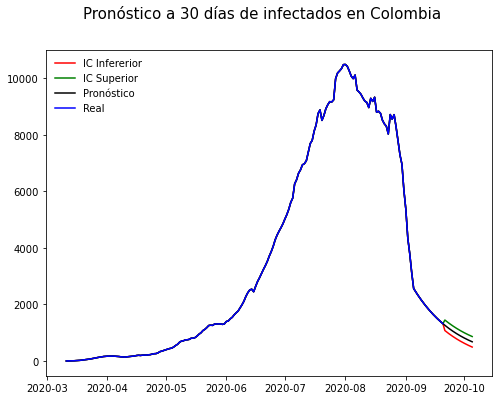

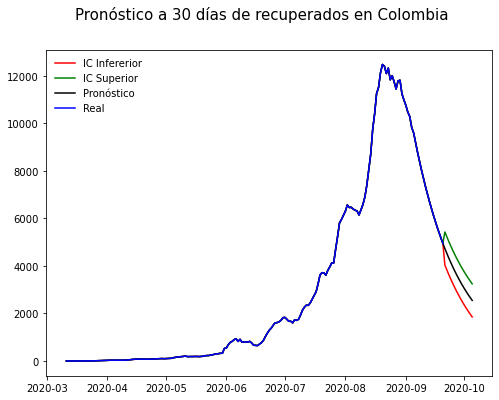

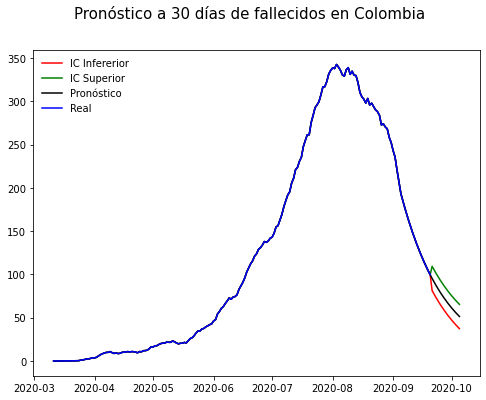

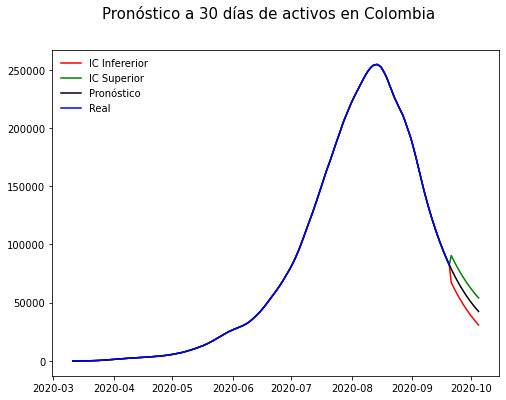

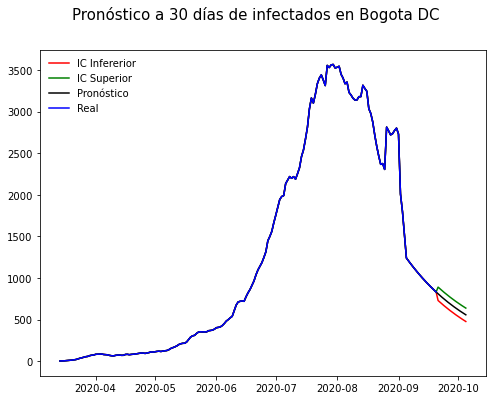

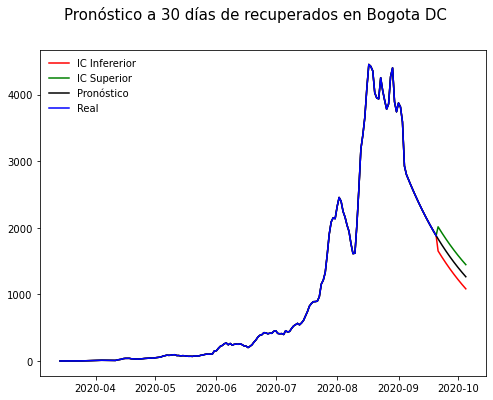

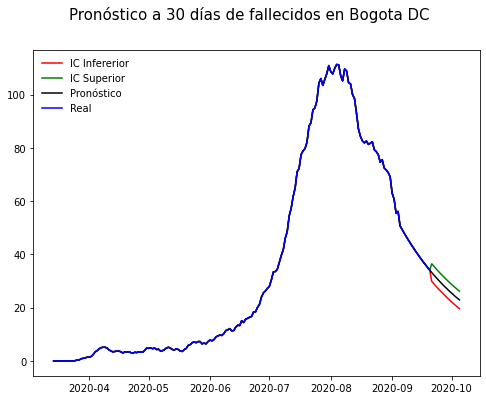

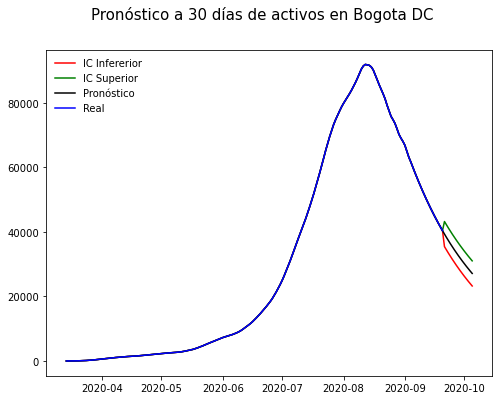

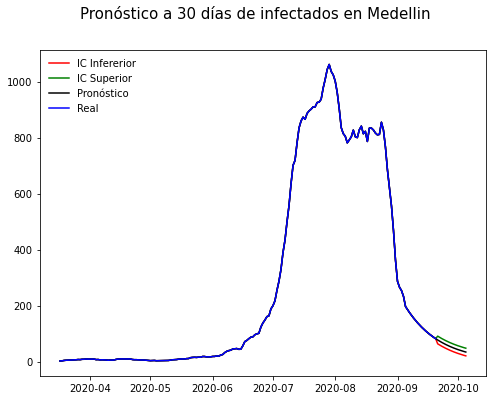

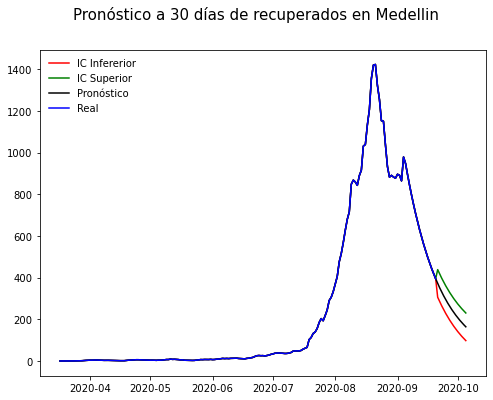

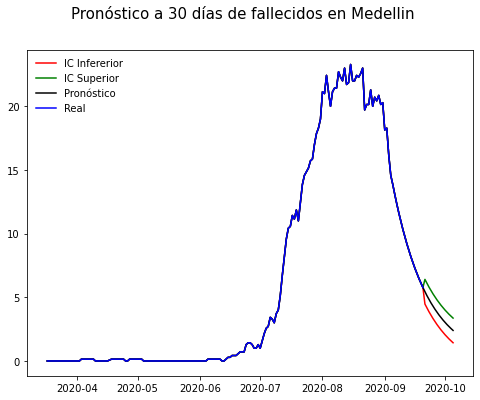

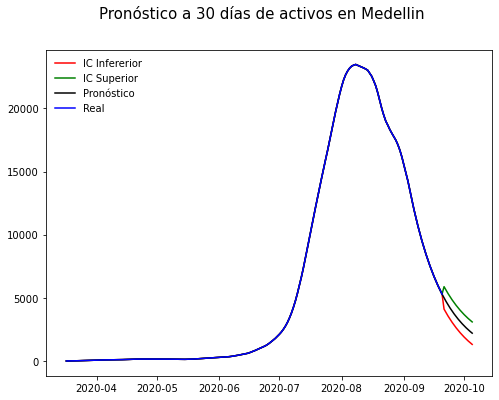

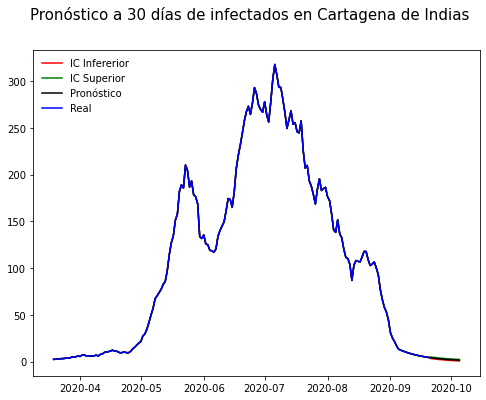

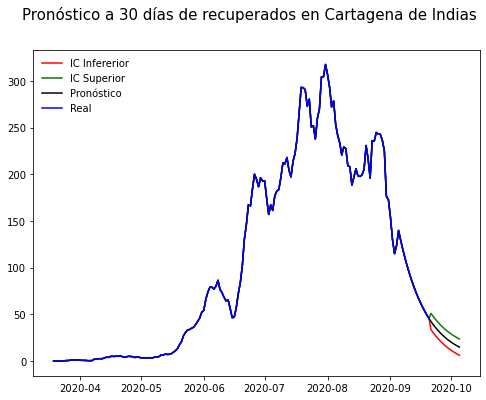

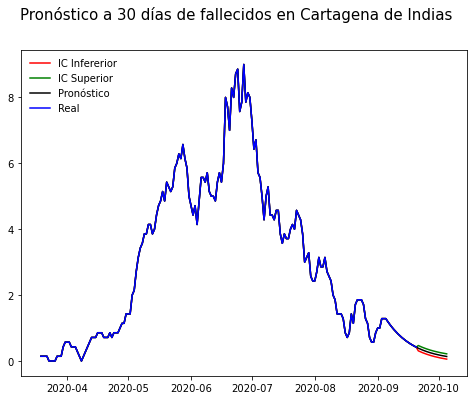

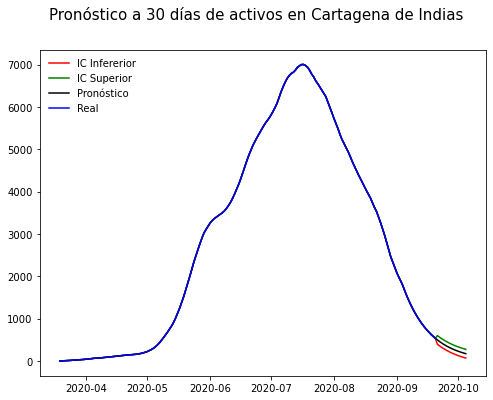

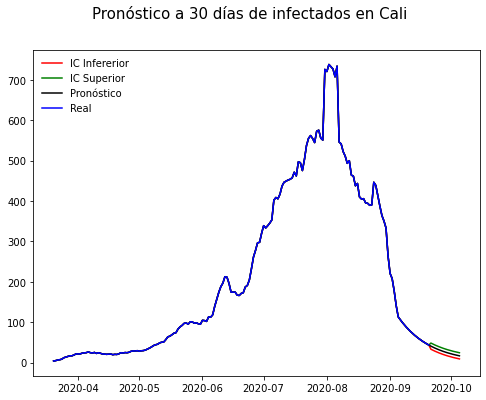

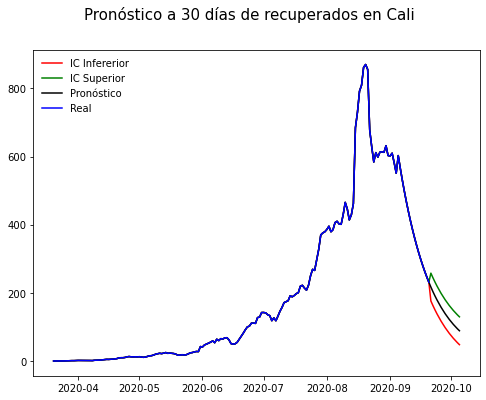

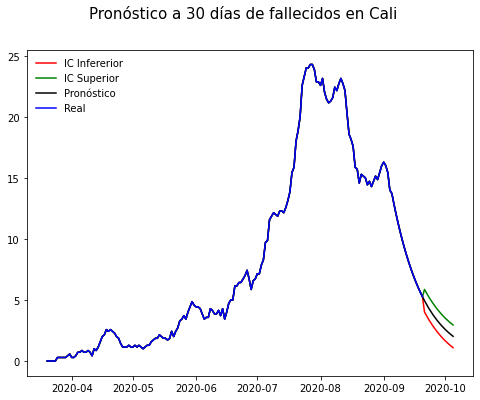

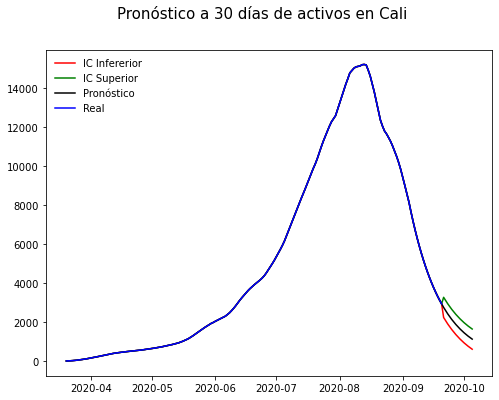

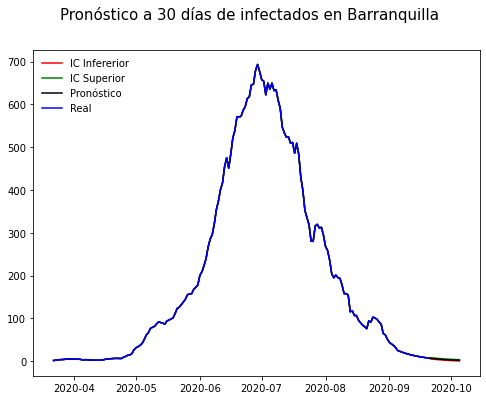

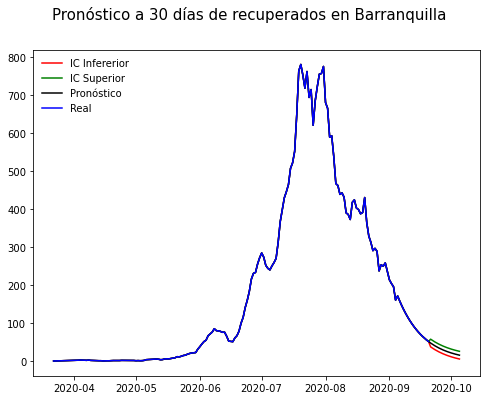

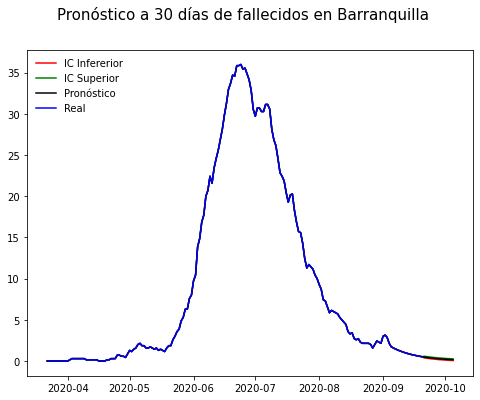

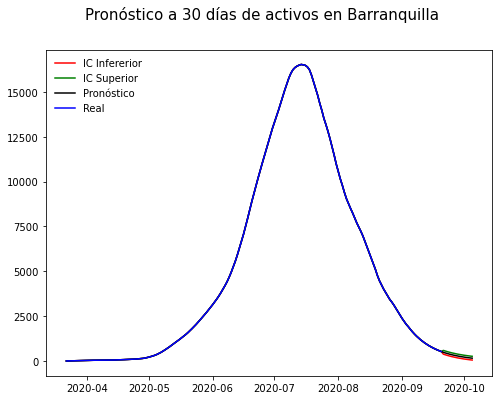

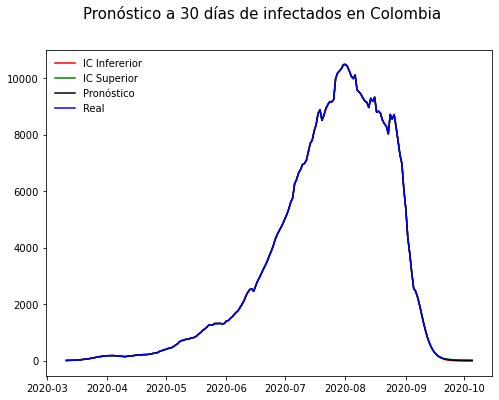

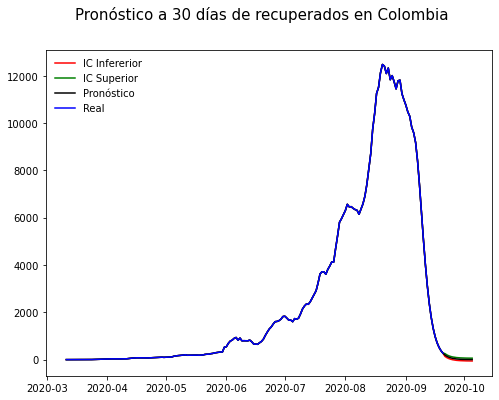

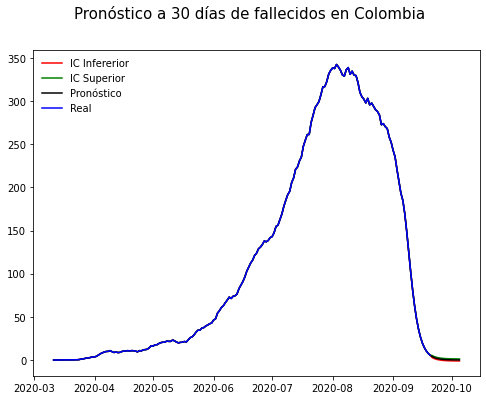

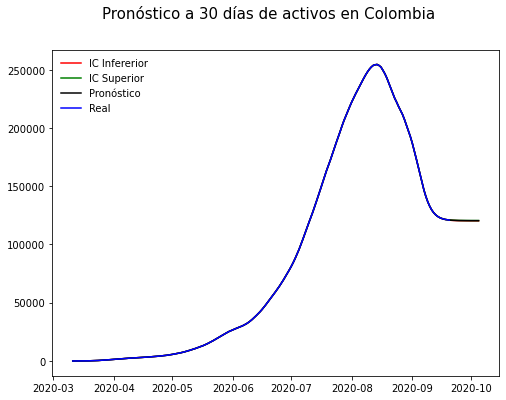

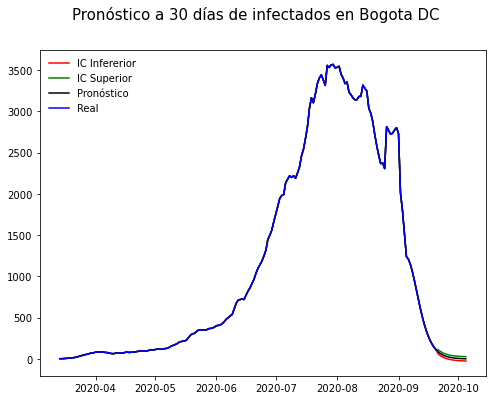

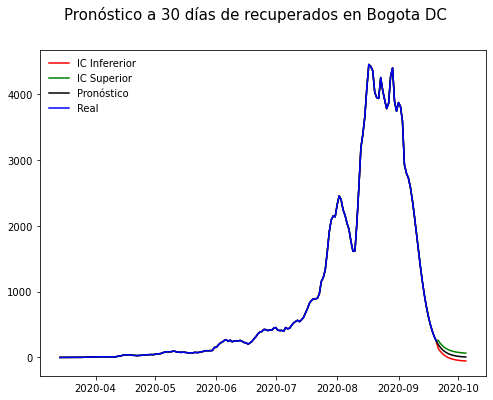

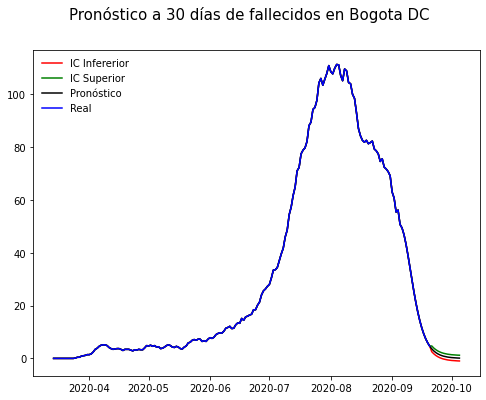

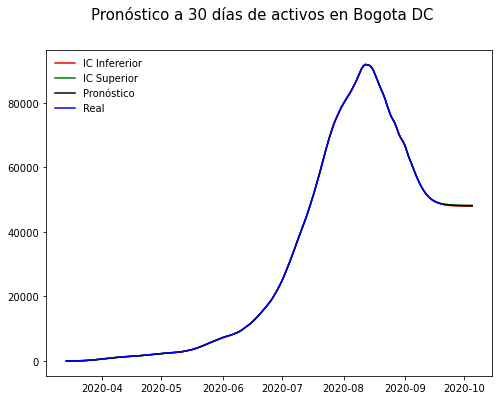

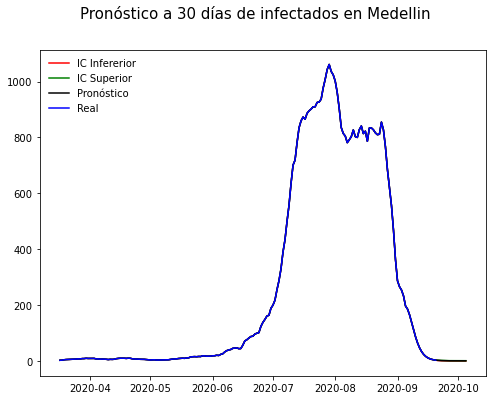

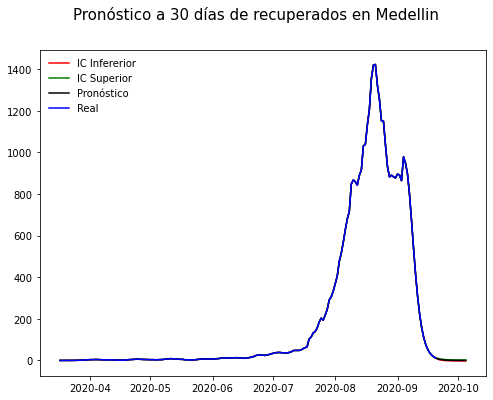

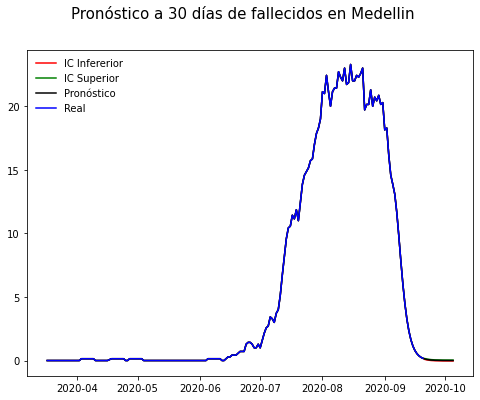

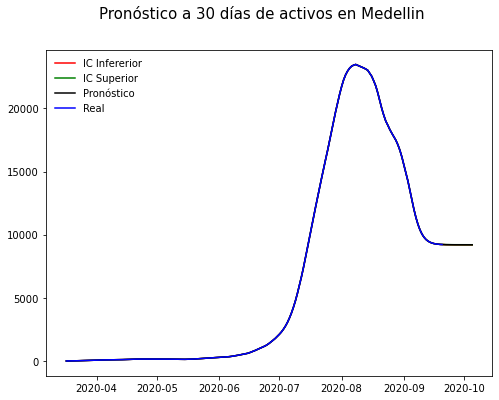

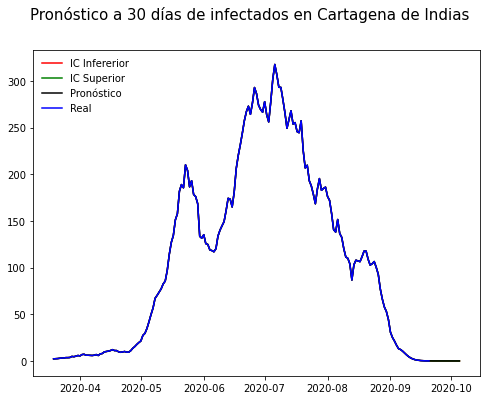

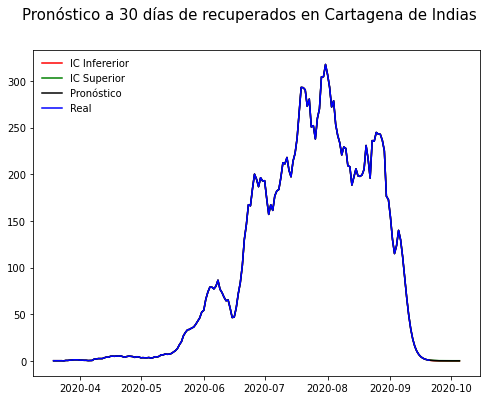

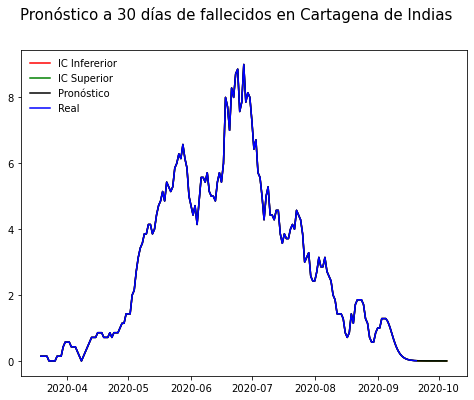

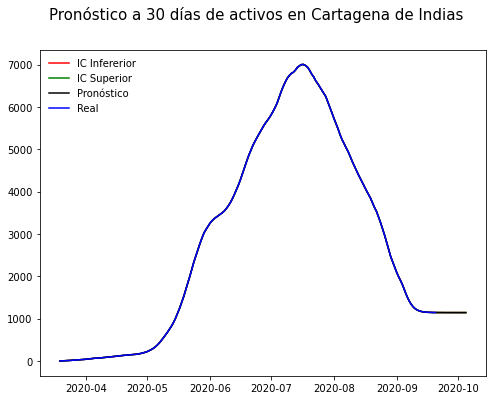

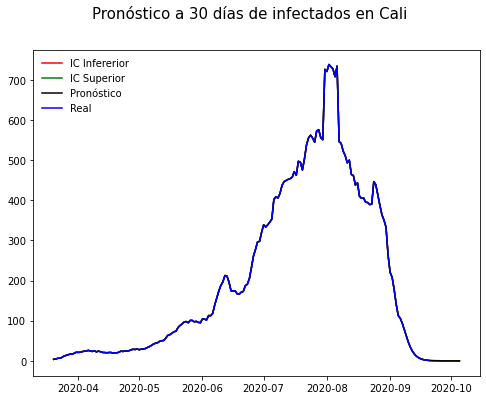

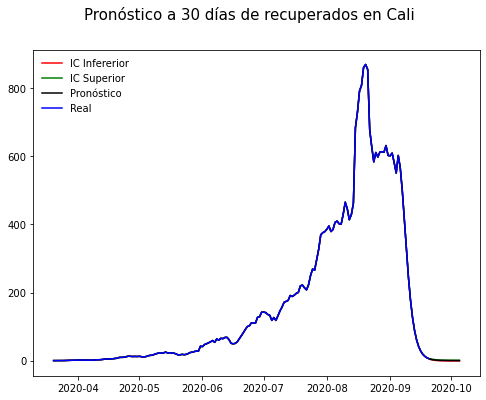

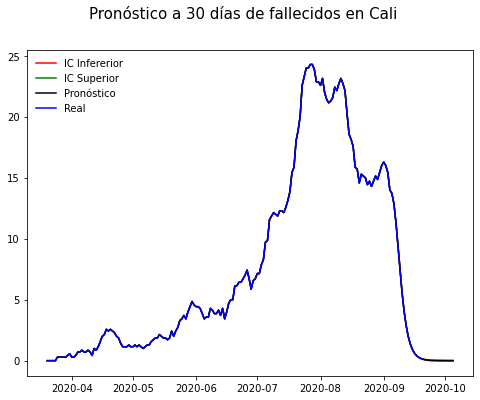

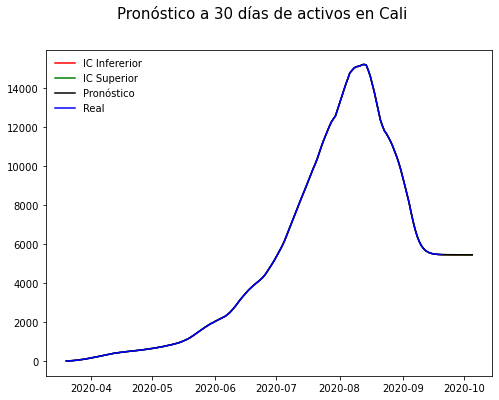

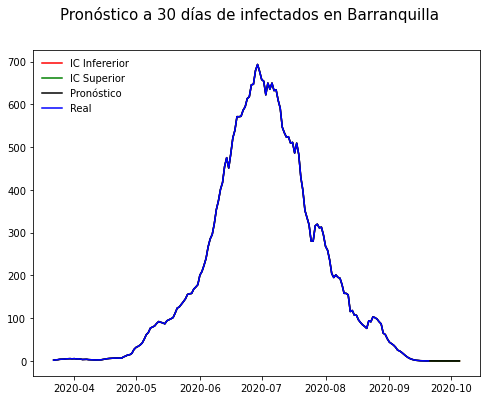

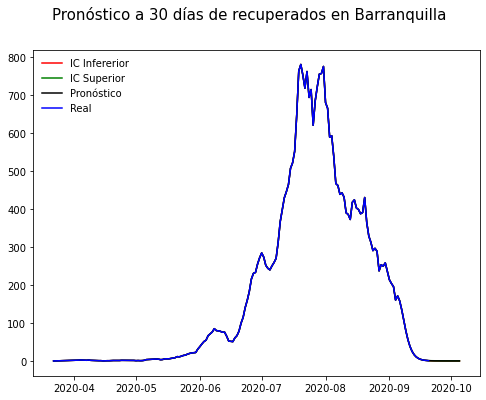

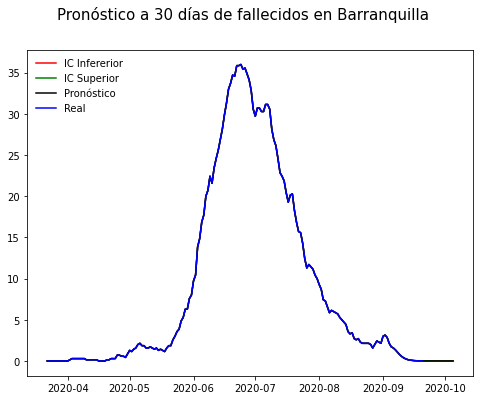

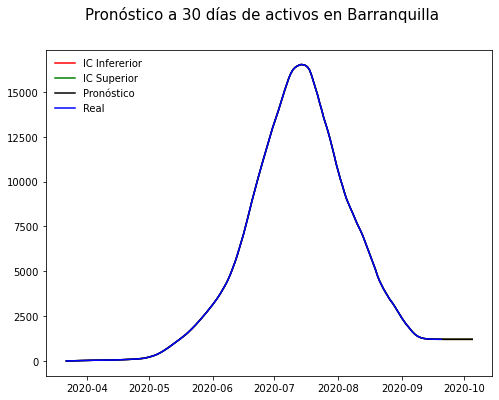

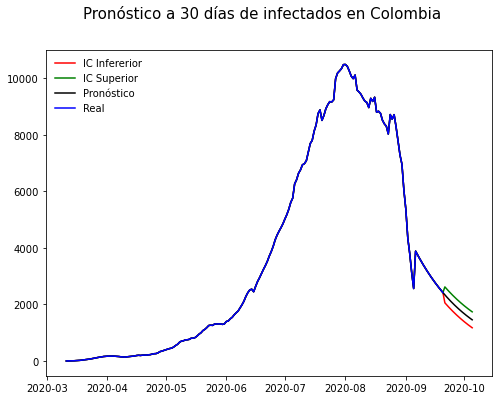

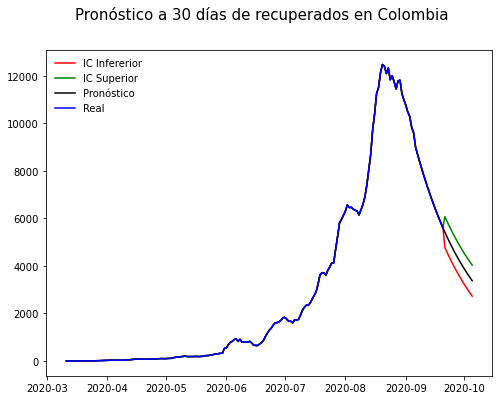

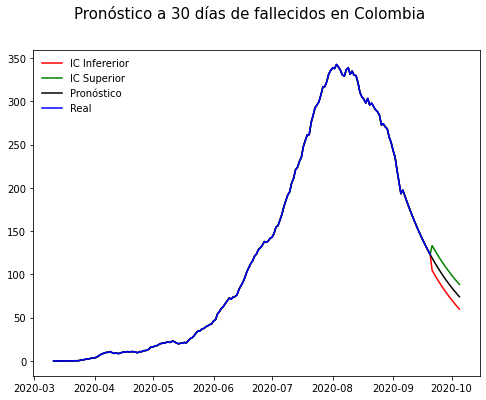

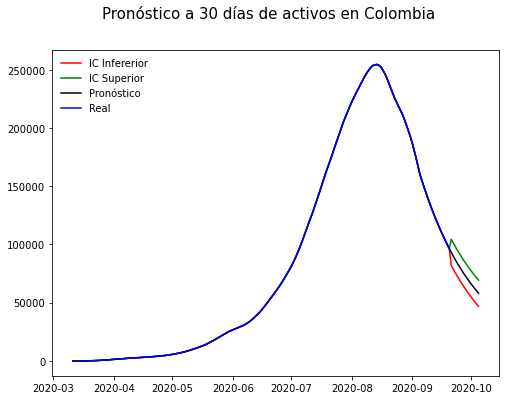

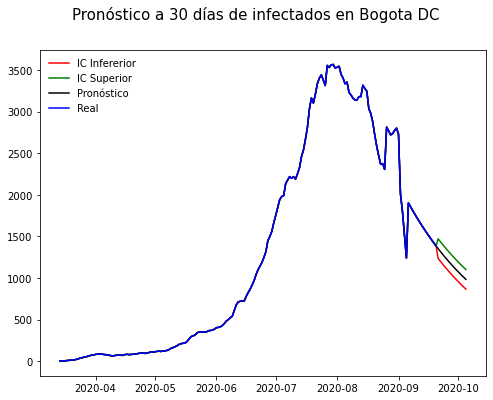

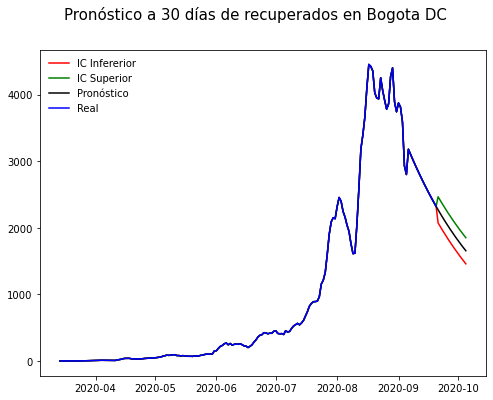

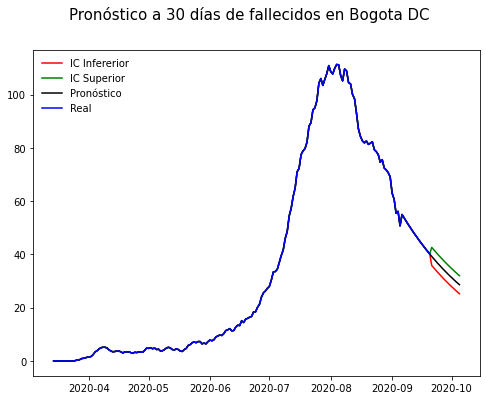

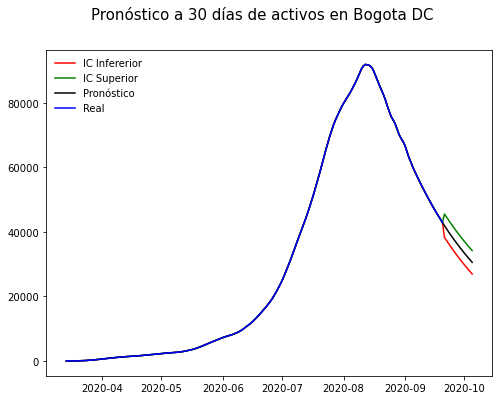

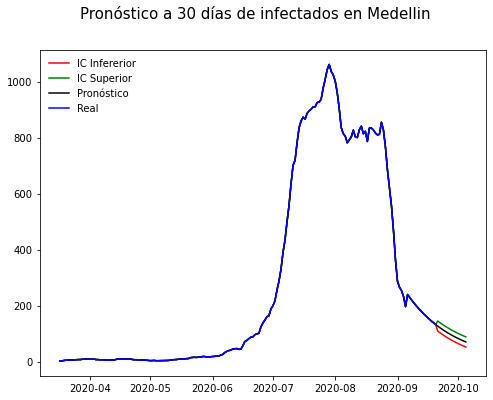

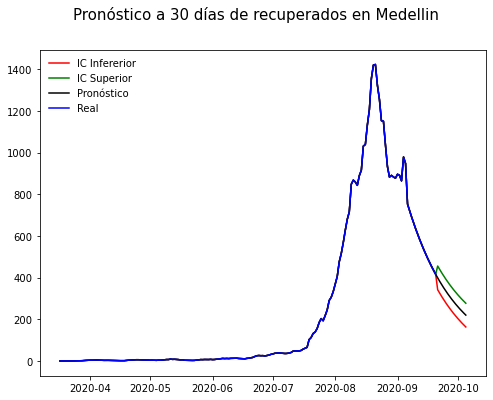

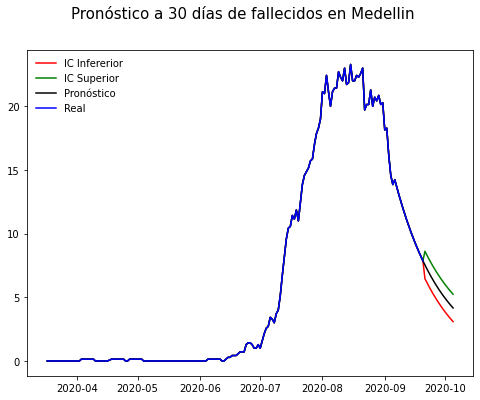

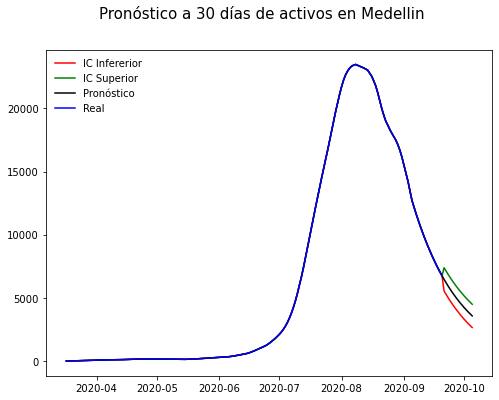

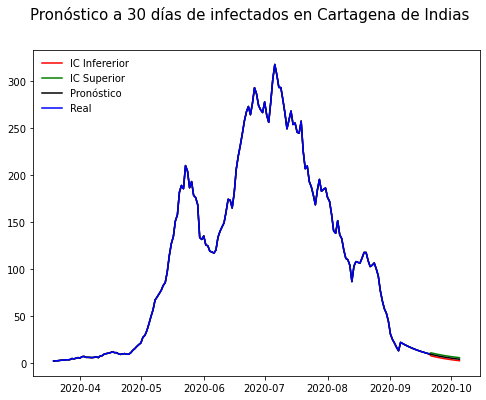

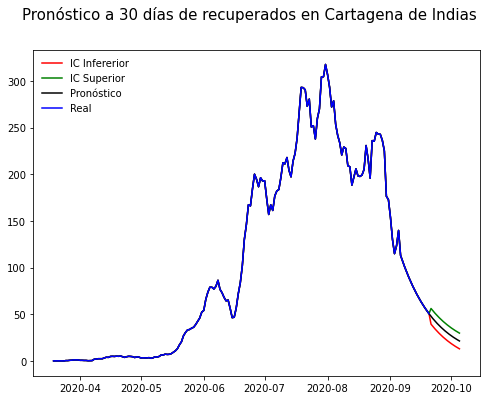

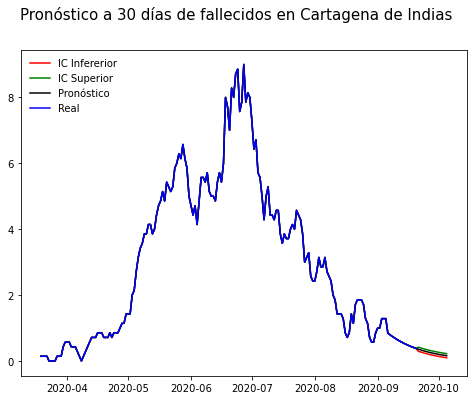

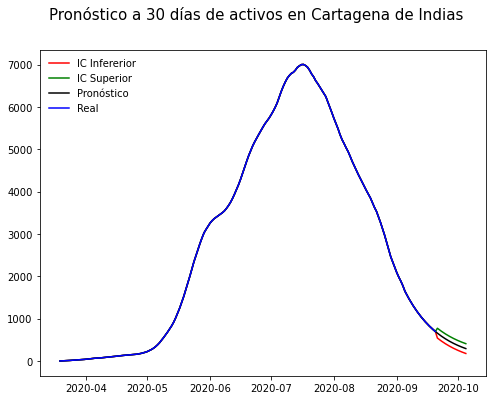

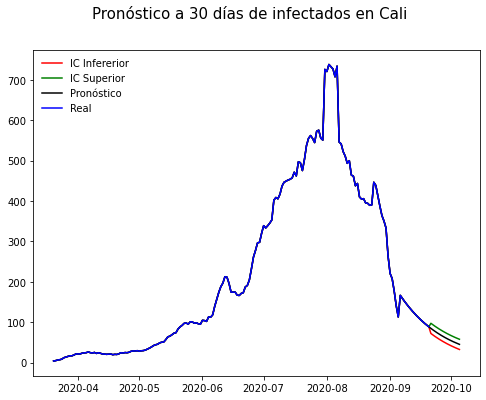

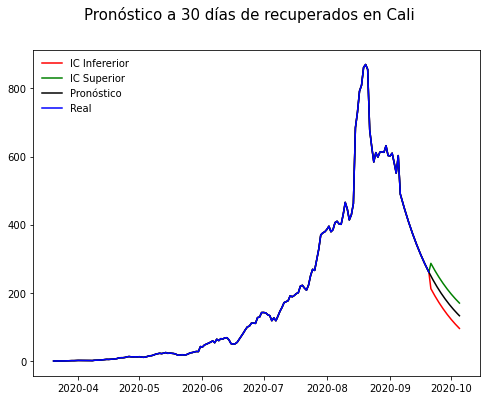

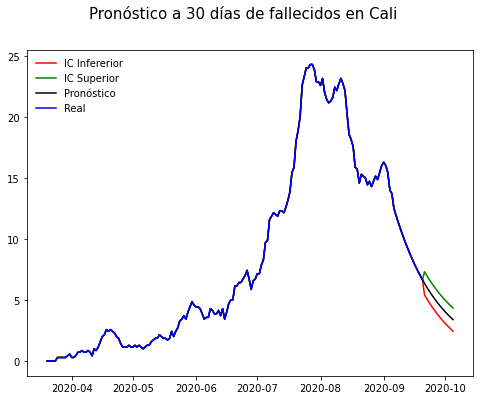

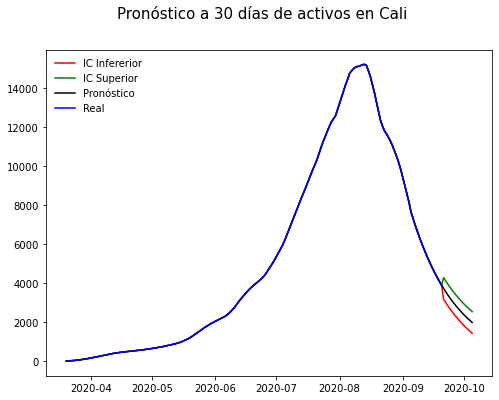

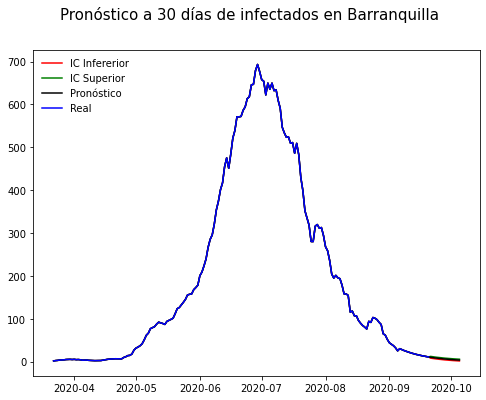

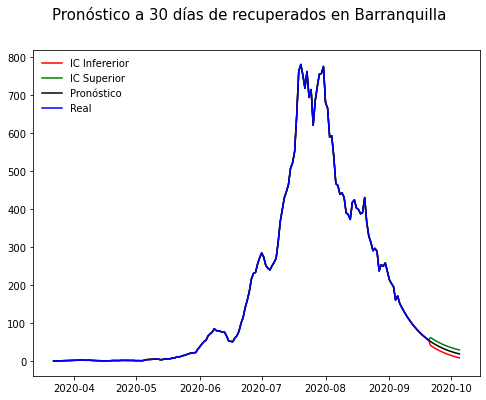

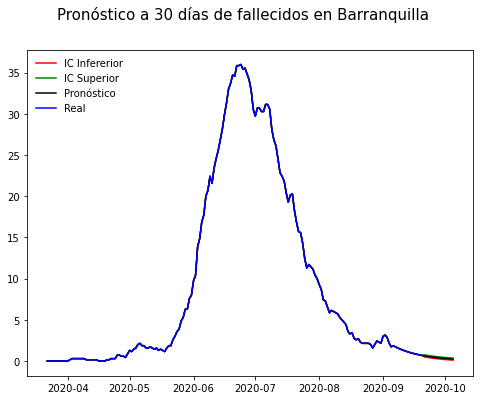

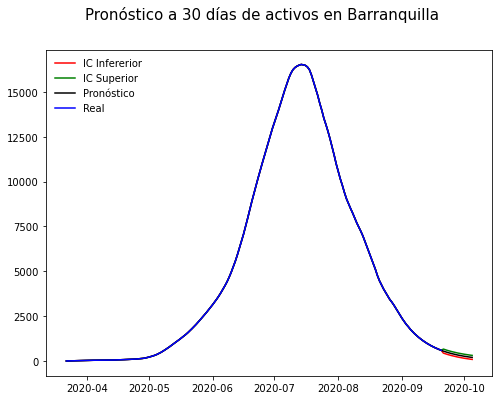

In [63]:
ciudades = ['Colombia', 'Bogota DC', 'Medellin', 'Cartagena de Indias', 'Cali', 'Barranquilla']
cal_parametros = ['last_param', 'last_param_cal', 'prom_param']
estado = ['infectados','recuperados','fallecidos','activos']
for param in cal_parametros:
    for ciudad in ciudades:
        prueba = df_pron30[(df_pron30['ciudad']== ciudad) & (df_pron30['escenario']== param)]
        
        for esta in estado:
            
            fig, ax = plt.subplots(1, figsize=(8, 6))
            fig.suptitle('Pronóstico a 30 días de ' + str(esta) + ' en ' + ciudad, fontsize=15)
            ax.plot(prueba['fecha'], prueba['ICi_'+esta], color = 'red', label="IC Infererior")
            ax.plot(prueba['fecha'], prueba['ICs_'+esta], color = 'green', label="IC Superior")
            ax.plot(prueba['fecha'], prueba['pronostico_'+esta], color='black', label="Pronóstico")
            ax.plot(prueba['fecha'], prueba[esta], color = 'blue', label='Real')
            ax.legend(loc="upper left", frameon=False)
            fig = plt.savefig('figuras/pronostico30/' + str(esta) + '/' + str(param) + '/pro_' + str(esta) + "_" + ciudad + '.png')

###### Gráficas de las curvas de casos para Colombia y sus principales ciudades

<ipython-input-64-aae7cd1aeff2>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, figsize=(8, 6))
<ipython-input-64-aae7cd1aeff2>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, figsize=(8, 6))
<ipython-input-64-aae7cd1aeff2>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


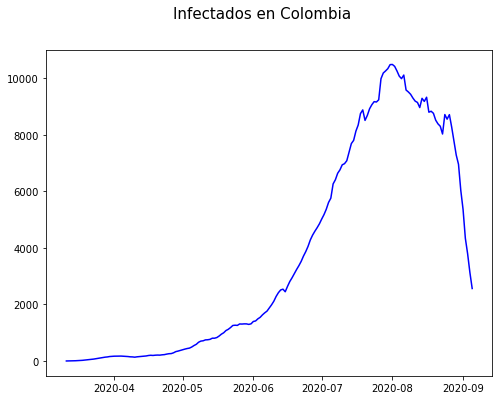

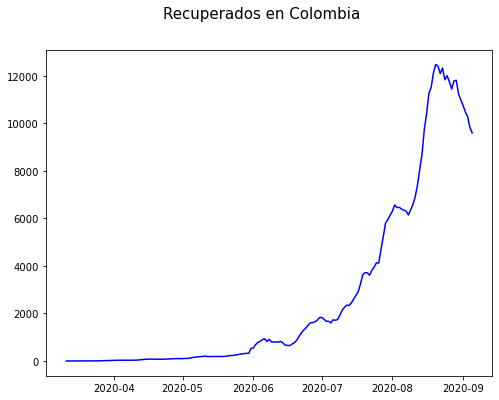

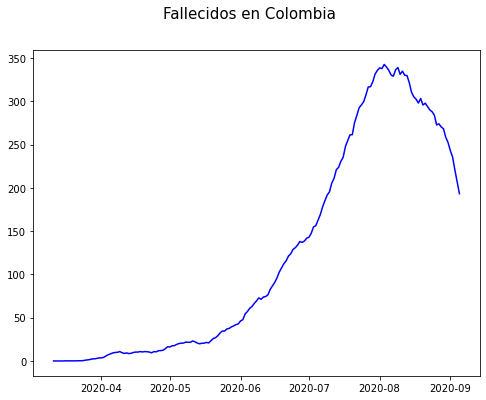

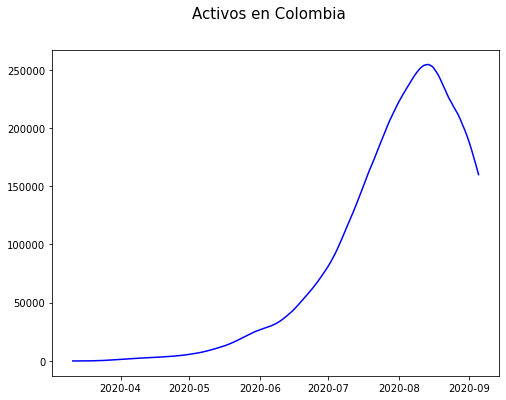

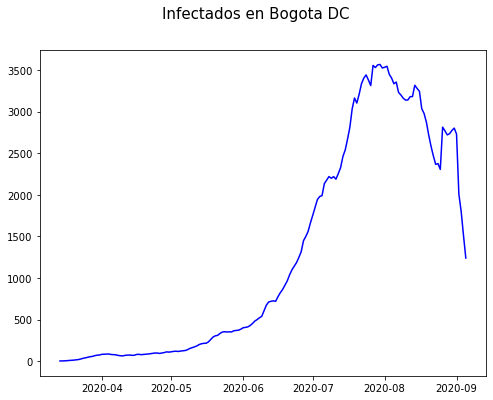

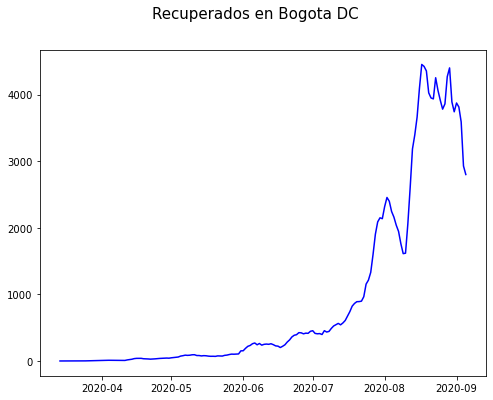

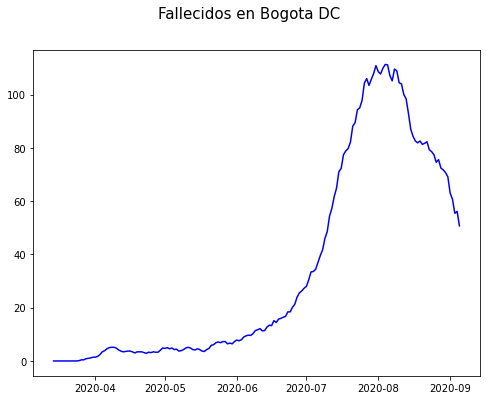

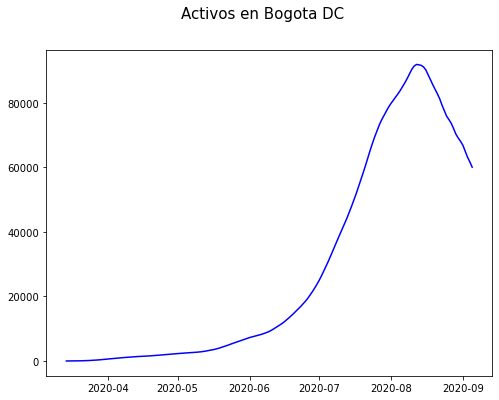

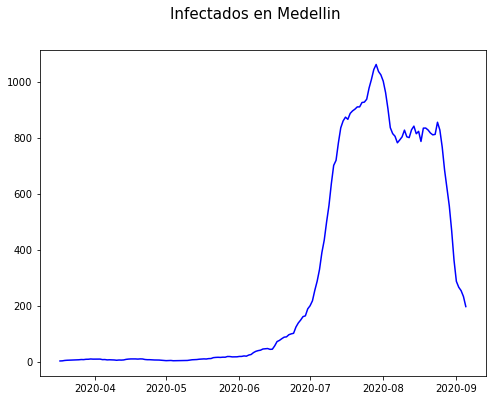

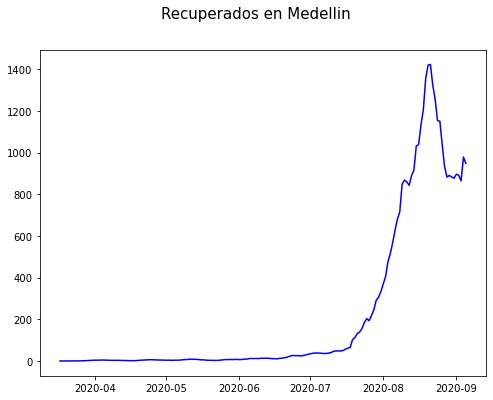

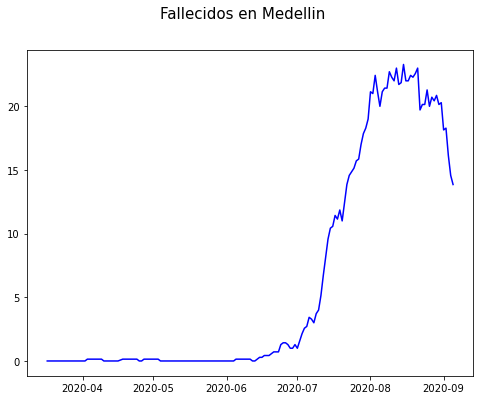

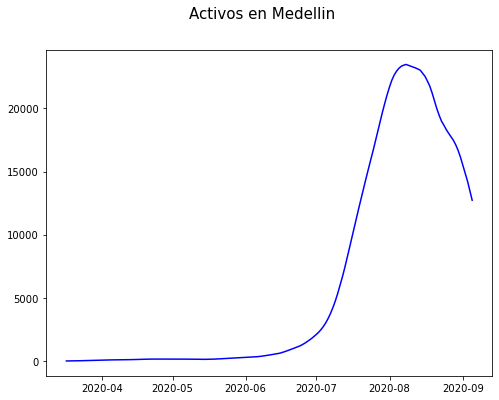

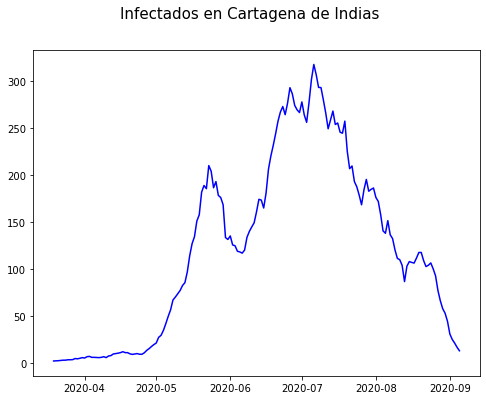

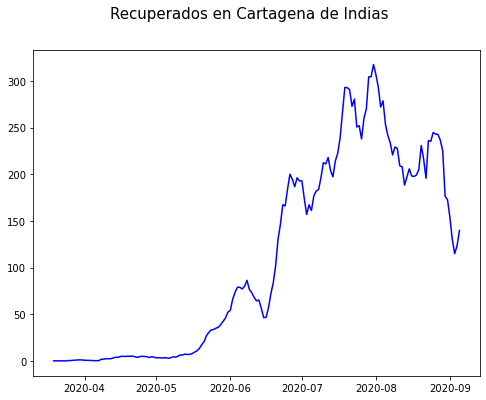

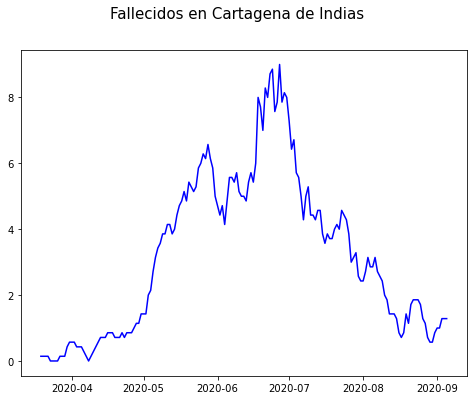

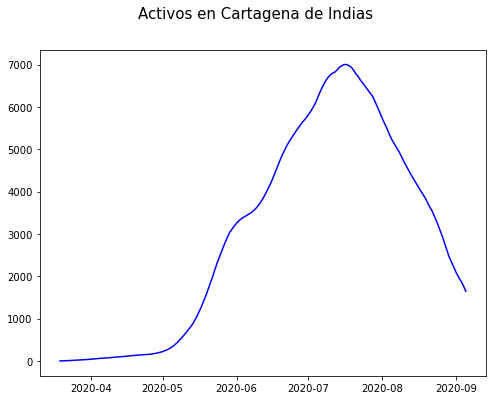

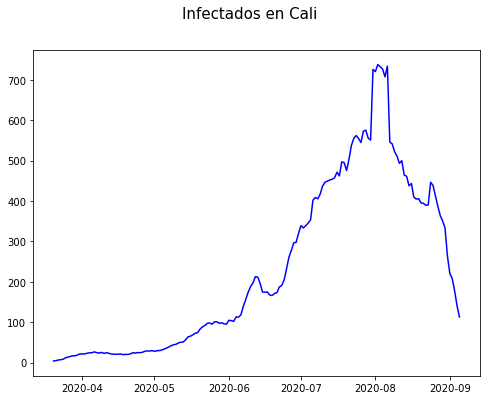

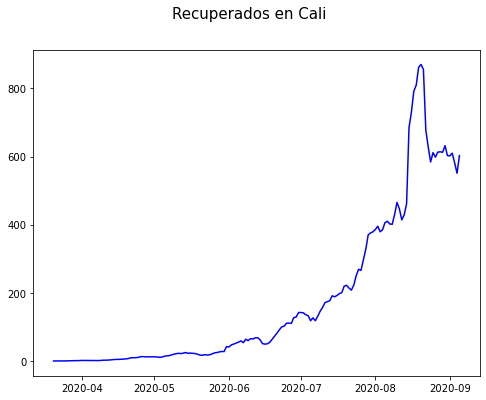

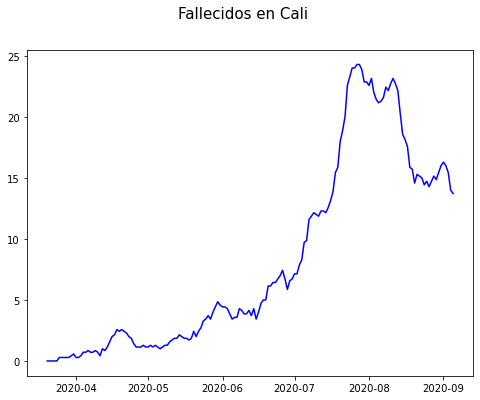

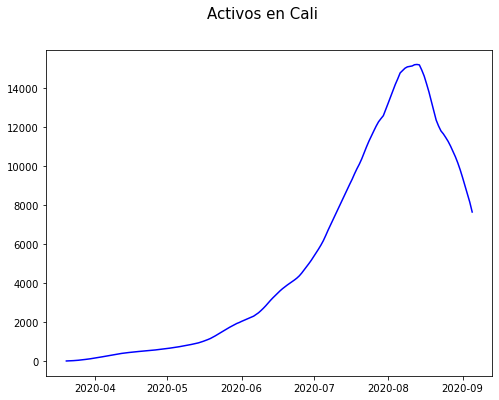

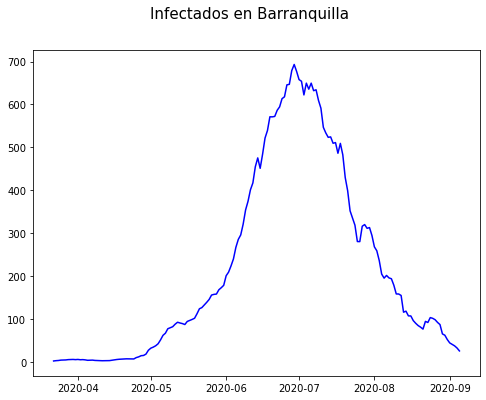

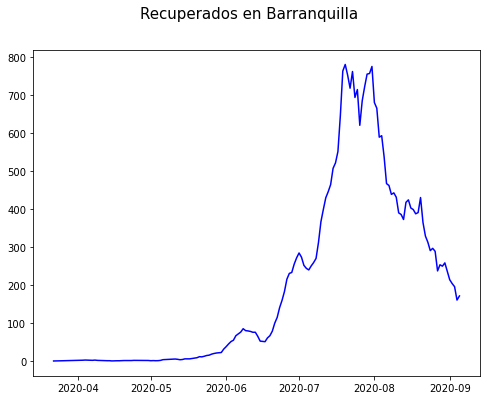

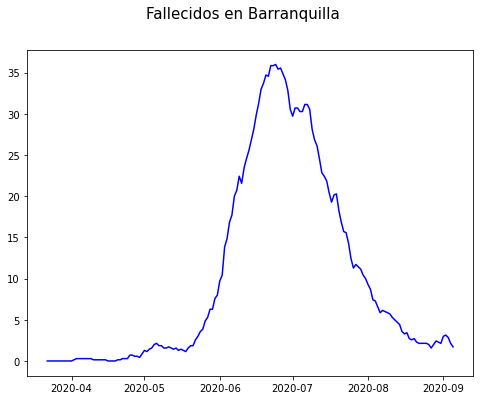

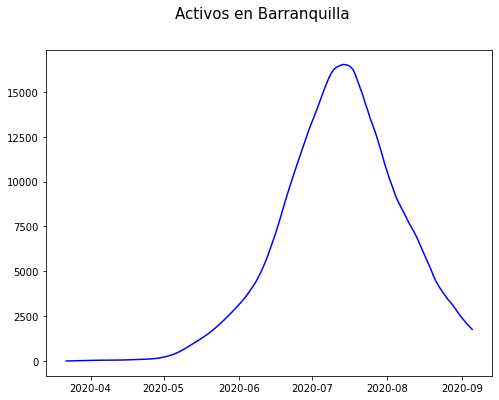

In [64]:
ciudades = ['Colombia', 'Bogota DC', 'Medellin', 'Cartagena de Indias', 'Cali', 'Barranquilla']
estado = ['infectados','recuperados','fallecidos','activos']

for ciudad in ciudades:
    prueba = df_pron15[(df_pron15['ciudad']== ciudad) & (df_pron15['escenario']== param)]

    for esta in estado:

        fig, ax = plt.subplots(1, figsize=(8, 6))
        fig.suptitle(str(esta).capitalize() + ' en ' + ciudad, fontsize=15)
        ax.plot(prueba['fecha'], prueba[esta], color = 'blue')
        fig = plt.savefig('figuras/curva_casos/' + str(esta) + '/pro_' + str(esta) + "_" + ciudad + '.png')

## Contrucción de tablas resumen para guardar como imagenes

In [65]:
#Funcion para poner bonitas las tablas
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], Edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(Edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

#render_mpl_table(df, header_columns=0, col_width=2.0)

In [66]:
ciudades = ['Colombia', 'Bogota DC', 'Medellin', 'Cartagena de Indias', 'Cali', 'Barranquilla']

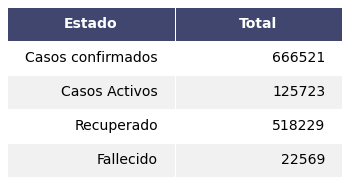

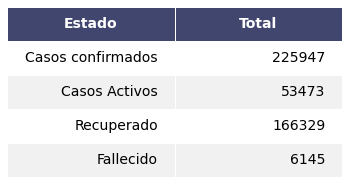

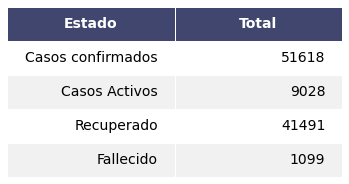

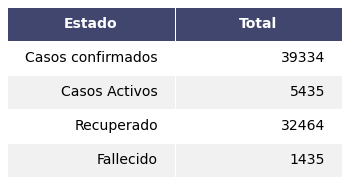

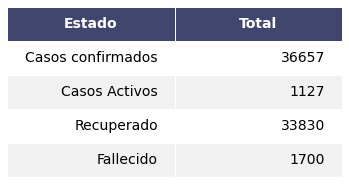

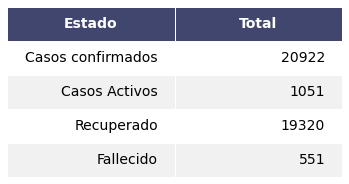

In [67]:
# Colombia
col = df.groupby(['atencion'])['ciudad'].count()
col['Casos confirmados'] = col['Activo'] + col['Casa'] + col['Hospital'] + col['Hospital uci'] + col['Recuperado'] + col['Fallecido']
col['Casos Activos'] = col['Activo'] + col['Casa'] + col['Hospital'] + col['Hospital uci']
col = pd.DataFrame(col[['Casos confirmados','Casos Activos','Recuperado','Fallecido']]).reset_index(drop=False)
col.columns = ['Estado', 'Total']
grafica = render_mpl_table(col, header_columns=0, col_width=3.0)
grafica = plt.savefig('figuras/tabla_resumen/resumen_Colombia.png')

# Bogota DC
bog = df[df['ciudad'] == 'Bogota DC'].groupby(['atencion'])['ciudad'].count()
bog['Casos confirmados'] = bog['Activo'] + bog['Casa'] + bog['Hospital'] + bog['Hospital uci'] + bog['Recuperado'] + bog['Fallecido']
bog['Casos Activos'] = bog['Activo'] + bog['Casa'] + bog['Hospital'] + bog['Hospital uci']
bog = pd.DataFrame(bog[['Casos confirmados','Casos Activos','Recuperado','Fallecido']]).reset_index(drop=False)
bog.columns = ['Estado', 'Total']
grafica = render_mpl_table(bog, header_columns=0, col_width=3.0)
grafica = plt.savefig('figuras/tabla_resumen/resumen_Bogota DC.png')

# Medellin
med = df[df['ciudad'] == 'Medellin'].groupby(['atencion'])['ciudad'].count()
med['Casos confirmados'] = med['Activo'] + med['Casa'] + med['Hospital'] + med['Hospital uci'] + med['Recuperado'] + med['Fallecido']
med['Casos Activos'] = med['Activo'] + med['Casa'] + med['Hospital'] + med['Hospital uci']
med = pd.DataFrame(med[['Casos confirmados','Casos Activos','Recuperado','Fallecido']]).reset_index(drop=False)
med.columns = ['Estado', 'Total']
grafica = render_mpl_table(med, header_columns=0, col_width=3.0)
grafica = plt.savefig('figuras/tabla_resumen/resumen_Medellin.png')

# Cali
cal = df[df['ciudad'] == 'Cali'].groupby(['atencion'])['ciudad'].count()
cal['Casos confirmados'] = cal['Activo'] + cal['Casa'] + cal['Hospital'] + cal['Hospital uci'] + cal['Recuperado'] + cal['Fallecido']
cal['Casos Activos'] = cal['Activo'] + cal['Casa'] + cal['Hospital'] + cal['Hospital uci']
cal = pd.DataFrame(cal[['Casos confirmados','Casos Activos','Recuperado','Fallecido']]).reset_index(drop=False)
cal.columns = ['Estado', 'Total']
grafica = render_mpl_table(cal, header_columns=0, col_width=3.0)
grafica = plt.savefig('figuras/tabla_resumen/resumen_Cali.png')

# Barraquilla
quilla = df[df['ciudad'] == 'Barranquilla'].groupby(['atencion'])['ciudad'].count()
quilla['Casos confirmados'] = quilla['Activo'] + quilla['Casa'] + quilla['Hospital'] + quilla['Hospital uci'] + quilla['Recuperado'] + quilla['Fallecido']
quilla['Casos Activos'] = quilla['Activo'] + quilla['Casa'] + quilla['Hospital'] + quilla['Hospital uci']
quilla = pd.DataFrame(quilla[['Casos confirmados','Casos Activos','Recuperado','Fallecido']]).reset_index(drop=False)
quilla.columns = ['Estado', 'Total']
grafica = render_mpl_table(quilla, header_columns=0, col_width=3.0)
grafica = plt.savefig('figuras/tabla_resumen/resumen_Barranquilla.png')

# Cartagena
cart = df[df['ciudad'] == 'Cartagena de Indias'].groupby(['atencion'])['ciudad'].count()
cart['Casos confirmados'] = cart['Activo'] + cart['Casa'] + cart['Hospital'] + cart['Hospital uci'] + cart['Recuperado'] + cart['Fallecido']
cart['Casos Activos'] = cart['Activo'] + cart['Casa'] + cart['Hospital'] + cart['Hospital uci']
cart = pd.DataFrame(cart[['Casos confirmados','Casos Activos','Recuperado','Fallecido']]).reset_index(drop=False)
cart.columns = ['Estado', 'Total']
grafica = render_mpl_table(cart, header_columns=0, col_width=3.0)
grafica = plt.savefig('figuras/tabla_resumen/resumen_Cartagena de Indias.png')

# Creación del dashboard de visualización con HTML

In [69]:
%%writefile DashCovidLME.html

<!doctype html>
<html lang="en">
<head>
    <!-- Required meta tags -->
    <meta charset="utf-8">
    <meta name="viewport" content="width=device-width, initial-scale=1, shrink-to-fit=no">
    <!-- Bootstrap CSS -->
    <link rel="stylesheet" href="https://stackpath.bootstrapcdn.com/bootstrap/4.3.1/css/bootstrap.min.css"
          integrity="sha384-ggOyR0iXCbMQv3Xipma34MD+dH/1fQ784/j6cY/iJTQUOhcWr7x9JvoRxT2MZw1T" crossorigin="anonymous">
    <title>Casos confirmados de COVID-19 en Colombia</title>

  <style>

        body {
          font-family: Arial, Helvetica, sans-serif;
          padding-left: 10px;
        }

        header {
            font-size: 20px;
        }

        nav1 {
          float: left;
          width: 20%;
          height: 150px;
          background-color: White;
          padding: 20px;
        }

        .seltext {
            font-weight: bold;
        }

        .auxtext {
            font-size: 14px;
            color: #807F7F;
        }

    </style>


</head>
<body>
<h1 align="center"><strong><FONT COLOR="Black">Casos confirmados de COVID-19 en Colombia</FONT></strong></h1>
<div class="container">
    <div class="row">
        <div class="col-sm">
            <div class="card">
                <div class="card-body">
                    Infectados: <strong><span id="connected_users">0</span></strong>
                </div>
            </div>
        </div>
        <div class="col-sm">
            <div class="card">
                <div class="card-body">
                    Recuperados: <strong><span id="daily_revenue">0</span></strong>
                </div>
            </div>
        </div>
        <div class="col-sm">
            <div class="card">
                <div class="card-body">
                    Muertos: <strong><span id="daily_revenue2">0</span></strong>
                </div>
            </div>
        </div>
    </div>
</div>

</header>
  <hr>
    <nav1 style="border:1px solid Gainsboro; border-width:2px;">
      <p class="seltext">Ciudad:</p><style="width:110px">
      <select id="region" name="region"  onchange="selectPlot()">
        <option value="casos_Colombia">Colombia</option>
        <option value="casos_Medellin">Medellín</option>
        <option value="casos_Bogota D.C.">Bogotá</option>
        <option value="casos_Cali">Cali</option>
        <option value="casos_Cartagena de Indias">Cartagena</option>
        <option value="casos_Barranquilla">Barranquilla</option>
      </select>
      
    </nav1>

    <div>
      <div class="myImage" id="casos_Colombia"   style="display:block"> <img src="figs/casos_Colombia.png"   alt="casos_Colombia">   </div>
      <div class="myImage" id="casos_Medellin"   style="display:none">  <img src="figs/casos_Medellin.png"   alt="casos_Medellin">   </div>
      <div class="myImage" id="casos_Bogota D.C."     style="display:none">  <img src="figs/casos_Bogota D.C..png"     alt="casos_Bogota D.C.">     </div>
      <div class="myImage" id="casos_Cali"   style="display:none">  <img src="figs/casos_Cali.png"   alt="casos_Cali">   </div>
      <div class="myImage" id="casos_Cartagena de Indias"  style="display:none">  <img src="figs/casos_Cartagena de Indias.png"  alt="casos_Cartagena de Indias">  </div>
      <div class="myImage" id="casos_Barranquilla"   style="display:none">  <img src="figs/casos_Barranquilla.png"   alt="casos_Barranquilla">   </div>
    </div>
  
    <div>
      <div class="myImage" id="casos_Colombia"   style="display:block"> <img src="figs/edad_Colombia.png"   alt="edad_Colombia">   </div>
      <div class="myImage" id="casos_Medellin"   style="display:none">  <img src="figs/edad_Medellin.png"   alt="edad_Medellin">   </div>
      <div class="myImage" id="casos_Bogota D.C."     style="display:none">  <img src="figs/edad_Bogota D.C..png"    alt="edad_Bogota D.C.">     </div>
      <div class="myImage" id="casos_Cali"   style="display:none">  <img src="figs/edad_Cali.png"   alt="edad_Cali">   </div>
      <div class="myImage" id="casos_Cartagena de Indias"  style="display:none">  <img src="figs/edad_Cartagena de Indias.png"    alt="edad_Cartagena de Indias">  </div>
      <div class="myImage" id="casos_Barranquilla"   style="display:none">  <img src="figs/edad_Barranquilla.png"    alt="edad_Barranquilla">   </div>
    </div>


    <script>
      function selectPlot() {
        var region = document.getElementById("region").value;
        var images = document.getElementsByClassName("myImage");
        for (var i = 0; i < images.length; i++) {
          if (images[i].id == region) {
            images[i].style.display = "block"
          }else{
            images[i].style.display = "none"
          }
        }
      }
    </script>
  <hr>
  <footer>
    <strong>Fuente de datos</strong>
    <ul>
      <li>https://www.datos.gov.co/Salud-y-Protecci-n-Social/Casos-positivos-de-COVID-19-en-Colombia/gt2j-8ykr/data</li>
    </ul>
  </footer>
</body>
</html>

Writing DashCovidLME.html
